
SVR Performance:
  R^2 Score:           0.6874
  Mean Squared Error:  1428.1674
  Mean Absolute Error: 26.0489
  PHM08 Score (sum):   3706892.2965
  PHM08 Score (avg):   898.2051

Poly(d=1)+LR Performance:
  R^2 Score:           0.6632
  Mean Squared Error:  1538.8371
  Mean Absolute Error: 30.4153
  PHM08 Score (sum):   5259331.0119
  PHM08 Score (avg):   1274.3715

Ensemble Performance:
  R^2 Score:           0.7022
  Mean Squared Error:  1360.6530
  Mean Absolute Error: 26.9330
  PHM08 Score (sum):   3371862.9448
  PHM08 Score (avg):   817.0252
Computing SHAP (KernelExplainer) for SVR (fast mode)...


  0%|          | 0/80 [00:00<?, ?it/s]

[INFO] SVR SHAP exceeded time cap; skipping SVR plots.
Computing SHAP (LinearExplainer) for Poly(d=1)+LR...


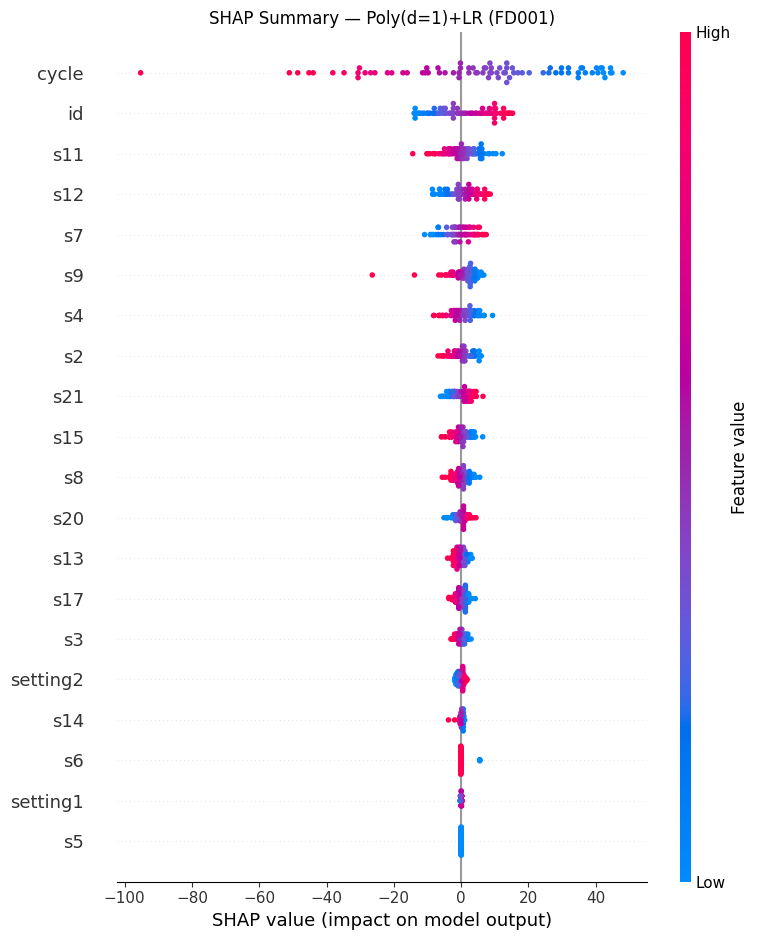

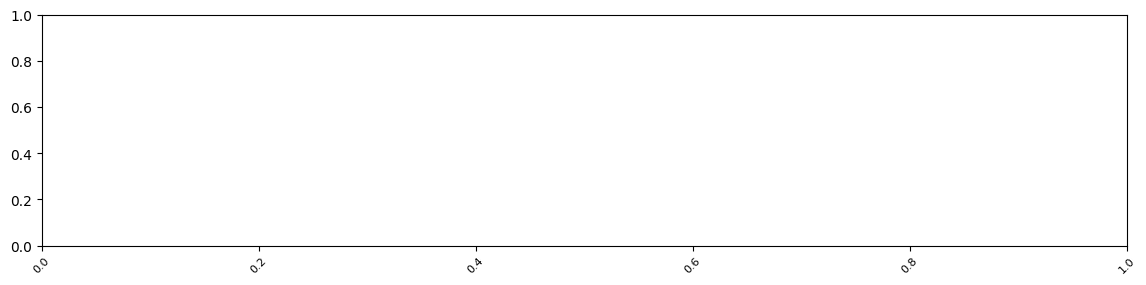

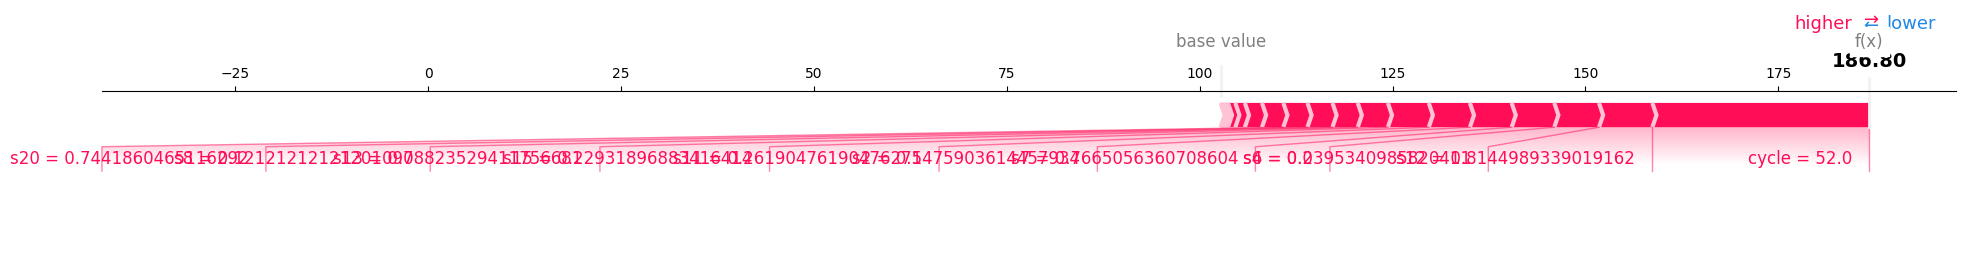

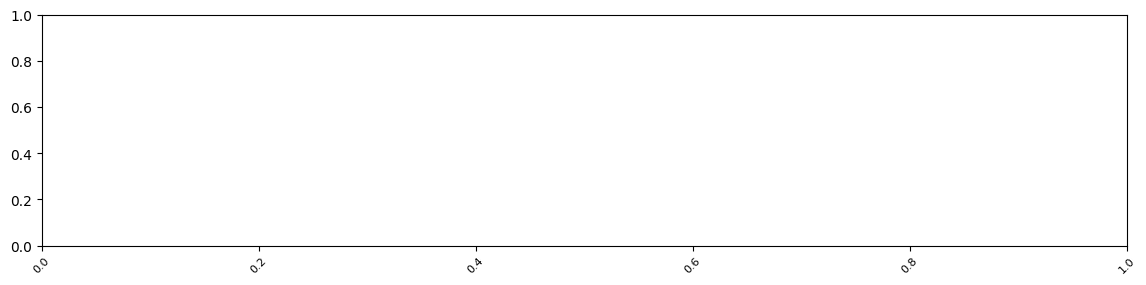

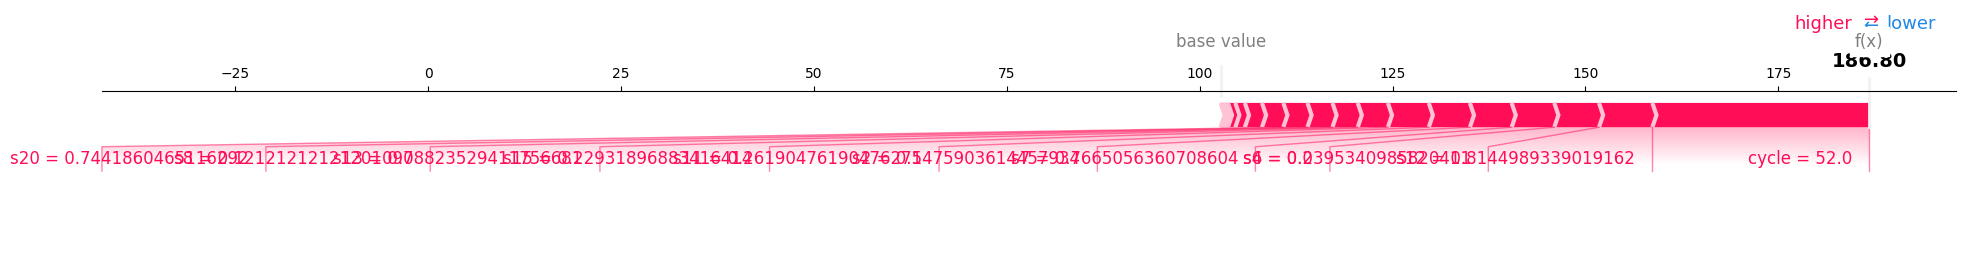

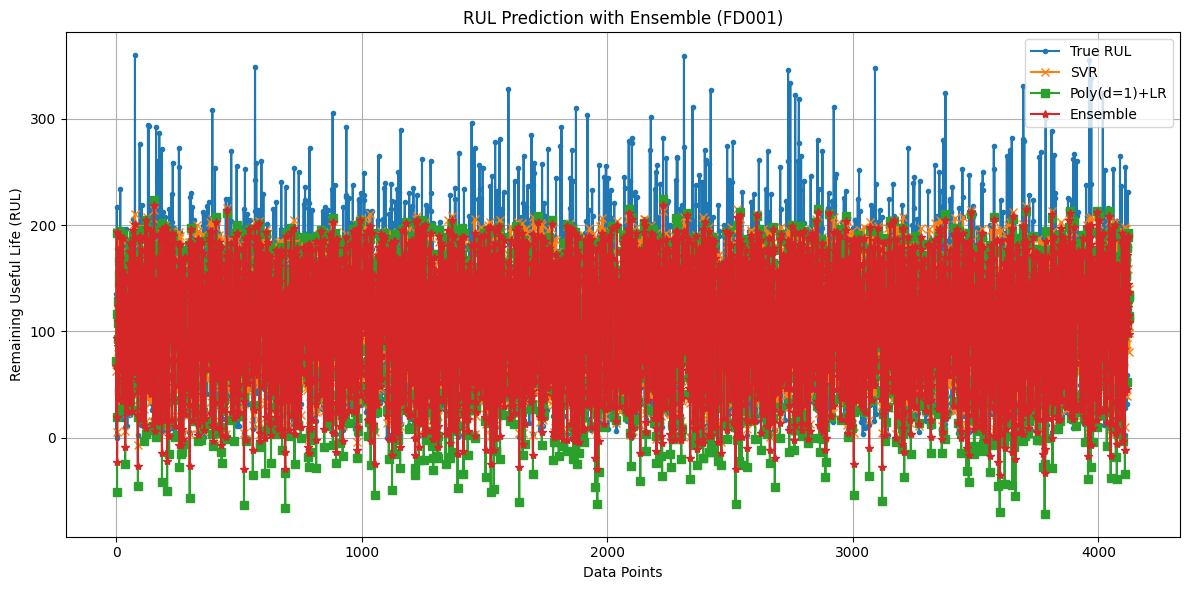



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (SVR) ---
Fold1: R2=0.6182, RMSE=43.7447, MAE=31.3085, PHM08_sum=14182468.6092, PHM08_avg=3442.3467
Fold2: R2=0.6929, RMSE=38.3891, MAE=24.6344, PHM08_sum=7129994.2073, PHM08_avg=1725.1377
Fold3: R2=0.6909, RMSE=38.3309, MAE=25.3102, PHM08_sum=4588997.2110, PHM08_avg=1112.2145
Fold4: R2=0.6584, RMSE=39.7150, MAE=28.7929, PHM08_sum=2803237.5201, PHM08_avg=679.5727
Fold5: R2=0.7313, RMSE=34.9232, MAE=25.8524, PHM08_sum=988138.3440, PHM08_avg=239.4326
Overall: R2=0.6774, RMSE=39.1222, MAE=27.1775, PHM08_sum=29692835.8917, PHM08_avg=1439.2340

--- GroupKFold (Poly(d=1)+LR) ---
Fold1: R2=0.5754, RMSE=46.1318, MAE=35.2302, PHM08_sum=19075812.6653, PHM08_avg=4630.0516
Fold2: R2=0.6571, RMSE=40.5615, MAE=30.2947, PHM08_sum=4074052.5036, PHM08_avg=985.7374
Fold3

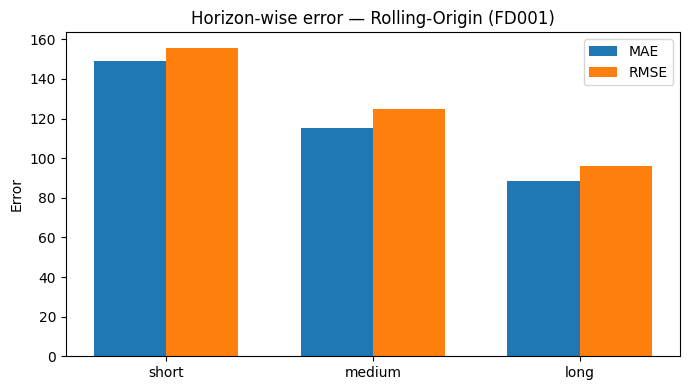

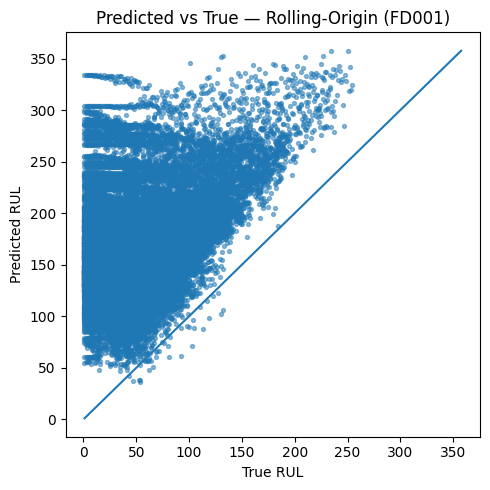


[PER-ENGINE MAE] (Top 10 worst engines)
96    171.005335
95    170.598113
69    166.412352
92    163.180027
67    161.426357
86    159.007467
18    156.858391
17    155.686430
46    146.359935
83    142.562241
dtype: float64


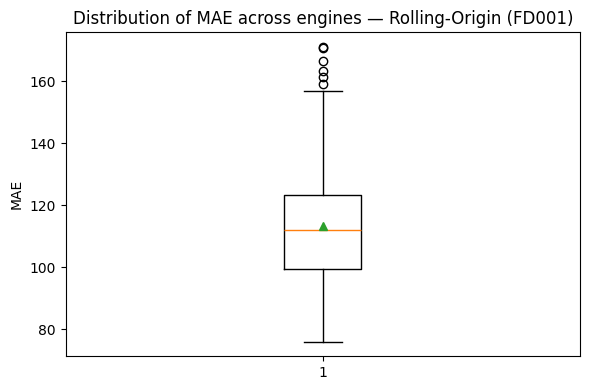

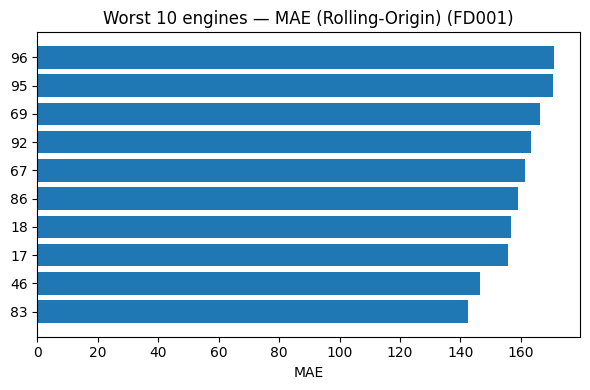


[ROLLING-ORIGIN OVERALL METRICS]
      R2: -8.7311
    RMSE: 129.0064
     MAE: 118.8614
 sMAPE_%: 113.2438

[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)
All features     : R²=0.6783 ± 0.0379
Without id/cycle : R²=0.6198 ± 0.0540


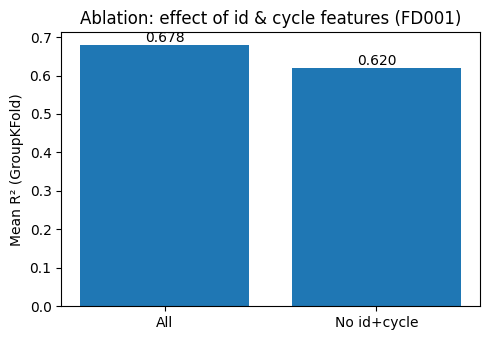


================ ROBUSTNESS ANALYSES COMPLETED ================


=== 80/20 SPLIT PROOF ===
Total samples : 20631
Train (80%)   : 16504  → ratio=0.8000
Test  (20%)   : 4127  → ratio=0.2000

=== RESOURCE USAGE REPORT ===
Elapsed time         : 951.89 seconds
CPU% at start        : 20.6%   (~0.53 GHz)
CPU% at end          : 14.0%   (~0.36 GHz)
Memory at start      : 469.99 MB
Memory at end        : 483.27 MB   (Δ 13.28 MB)


In [4]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD001"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "svrpoly"

# Fixed model hyperparameters (as requested)
SVM_PARAMS = dict(
    C=500,
    epsilon=0.5,
    gamma='scale',
    kernel='rbf'
)

POLY_DEGREE = 1
LINEAR_PARAMS = dict(
    fit_intercept=True
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.base import clone
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

warnings.filterwarnings("ignore")

# ============================================
# Output paths — single, unified directory
# ============================================
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# ============================================
# Model training (SVR + Polynomial(1)+LinearRegression)
# ============================================
svr_model = SVR(**SVM_PARAMS)
svr_model.fit(X_train, y_train)
y_svr = svr_model.predict(X_val)

poly_model = Pipeline([
    ('poly', PolynomialFeatures(degree=POLY_DEGREE)),
    ('lin',  LinearRegression(**LINEAR_PARAMS))
])
poly_model.fit(X_train, y_train)
y_poly = poly_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_svr + 0.5 * y_poly

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_svr = print_block_metrics("SVR",         y_val, y_svr)
m_poly= print_block_metrics("Poly(d=1)+LR",y_val, y_poly)
m_ens = print_block_metrics("Ensemble",    y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_svr, m_poly, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations (fast & resilient)
# ============================================
FAST_SHAP_MAX_SECS = 120         # hard cap; if exceeded we skip SVR SHAP
SVR_NSAMPLES       = 60          # lower is faster; 50–100 reasonable
N_BG               = min(50, X_train.shape[0])
N_SUM              = min(80,  X_val.shape[0])

rng = np.random.default_rng(42)
bg_idx   = rng.choice(X_train.index, size=N_BG, replace=False)
X_bg_np  = X_train.loc[bg_idx].to_numpy(dtype=np.float32)
X_shap   = X_val.sample(n=N_SUM, random_state=42)
X_shap_np= X_shap.to_numpy(dtype=np.float32)
feature_names = X.columns.tolist()

# ---- SVR: KernelExplainer with tiny background + few evaluations
import time as _time
print("Computing SHAP (KernelExplainer) for SVR (fast mode)...")
_t0 = _time.time()
shap_vals_svr = None
try:
    svr_explainer = shap.KernelExplainer(lambda X_: svr_model.predict(np.asarray(X_, dtype=np.float32)),
                                         X_bg_np)
    shap_vals_svr = svr_explainer.shap_values(X_shap_np, nsamples=SVR_NSAMPLES, l1_reg="num_features(10)")
    if _time.time() - _t0 > FAST_SHAP_MAX_SECS:
        print("[INFO] SVR SHAP exceeded time cap; skipping SVR plots.")
        shap_vals_svr = None
except Exception as e:
    print(f"[WARN] SVR SHAP failed: {e}")
    shap_vals_svr = None

if shap_vals_svr is not None:
    shap.summary_plot(shap_vals_svr, X_shap, feature_names=feature_names, show=False)
    plt.title(f"SHAP Summary — SVR ({DATASET_NAME})")
    plt.tight_layout(); save_png(f"SHAP_Summary_SVR_{DATASET_NAME}.png"); plt.show()

# ---- Poly(d=1)+LR: exact & fast via LinearExplainer on pipeline internals
print("Computing SHAP (LinearExplainer) for Poly(d=1)+LR...")
poly_step = poly_model.named_steps['poly']
lin_step  = poly_model.named_steps['lin']

X_bg_poly   = poly_step.transform(X_bg_np)
X_shap_poly = poly_step.transform(X_shap_np)
poly_feat_names = list(poly_step.get_feature_names_out(input_features=feature_names))

lin_explainer  = shap.LinearExplainer(lin_step, X_bg_poly)
shap_vals_poly = lin_explainer.shap_values(X_shap_poly)

shap.summary_plot(shap_vals_poly, pd.DataFrame(X_shap_poly, columns=poly_feat_names),
                  feature_names=poly_feat_names, show=False)
plt.title(f"SHAP Summary — Poly(d=1)+LR ({DATASET_NAME})")
plt.tight_layout(); save_png(f"SHAP_Summary_PolyLR_{DATASET_NAME}.png"); plt.show()

# ---- Optional ensemble plot (only if SVR SHAP available & same dimensionality)
if shap_vals_svr is not None and np.shape(shap_vals_svr) == np.shape(shap_vals_poly):
    shap_vals_ens = (np.asarray(shap_vals_svr) + np.asarray(shap_vals_poly)) / 2.0
    shap.summary_plot(shap_vals_ens, X_shap, feature_names=feature_names, show=False)
    plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
    plt.tight_layout(); save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png"); plt.show()

# ---- Single-row force plots (guarded)
try:
    row = X_shap.iloc[[0]]
    f_row = row.iloc[0].values

    # SVR: use mean prediction over background as expected value
    if shap_vals_svr is not None:
        expected_svr = float(np.mean(svr_model.predict(X_bg_np)))
        sv_svr_row   = np.asarray(shap_vals_svr)[0]
        fig, ax = plt.subplots(figsize=(14, 3))
        _ = shap.force_plot(expected_svr, sv_svr_row, f_row,
                            feature_names=row.columns.tolist(), matplotlib=True, show=False)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        plt.tight_layout(); save_png(f"Local_SHAP_force_SVR_Single_{DATASET_NAME}.png"); plt.show()

    # Poly(d=1)+LR: expected via linear model on background (fast & exact)
    expected_poly = float(np.mean(lin_step.predict(X_bg_poly)))
    sv_poly_row   = np.asarray(shap_vals_poly)[0]
    row_poly      = poly_step.transform(row.values)[0]  # transformed feature vector
    fig, ax = plt.subplots(figsize=(14, 3))
    _ = shap.force_plot(expected_poly, sv_poly_row, row_poly,
                        feature_names=poly_feat_names, matplotlib=True, show=False)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    plt.tight_layout(); save_png(f"Local_SHAP_force_PolyLR_Single_{DATASET_NAME}.png"); plt.show()

    # Ensemble force plot only if dimensions match
    if shap_vals_svr is not None and len(sv_svr_row) == len(sv_poly_row):
        expected_ens = 0.5*expected_svr + 0.5*expected_poly
        sv_ens_row   = 0.5*sv_svr_row + 0.5*sv_poly_row
        fig, ax = plt.subplots(figsize=(14, 3))
        _ = shap.force_plot(expected_ens, sv_ens_row, f_row,
                            feature_names=row.columns.tolist(), matplotlib=True, show=False)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        plt.tight_layout(); save_png(f"Local_SHAP_force_Ensemble_Single_{DATASET_NAME}.png"); plt.show()

except Exception as e:
    print(f"[WARN] Local force plots skipped: {e}")


# Single-row force plots (SVR / Poly / Ensemble) — SAFE RE-RUN
# (Fix: use shap_vals_svr / shap_vals_poly; use row_poly for Poly; guard when SVR SHAP is None)
try:
    row = X_shap.iloc[[0]]
    f_row = row.iloc[0].values

    # SVR expected value & SHAP row (only if available)
    if shap_vals_svr is not None:
        expected_svr = float(np.mean(svr_model.predict(X_bg_np)))
        sv_svr_row   = np.asarray(shap_vals_svr)[0]
    else:
        expected_svr = None
        sv_svr_row   = None

    # Poly(d=1)+LR expected value & SHAP row (poly feature space!)
    expected_poly = float(np.mean(lin_step.predict(X_bg_poly)))
    sv_poly_row   = np.asarray(shap_vals_poly)[0]
    row_poly      = poly_step.transform(row.values)[0]  # transformed feature vector

    # --- Plot: SVR (only if SHAP for SVR was computed)
    if sv_svr_row is not None:
        fig, ax = plt.subplots(figsize=(14, 3))
        _ = shap.force_plot(expected_svr, sv_svr_row, f_row,
                            feature_names=row.columns.tolist(), matplotlib=True, show=False)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        plt.tight_layout()
        save_png(f"Local_SHAP_force_SVR_Single_{DATASET_NAME}.png")
        plt.show()

    # --- Plot: Poly(d=1)+LR (use polynomial features!)
    fig, ax = plt.subplots(figsize=(14, 3))
    _ = shap.force_plot(expected_poly, sv_poly_row, row_poly,
                        feature_names=poly_feat_names, matplotlib=True, show=False)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    plt.tight_layout()
    save_png(f"Local_SHAP_force_PolyLR_Single_{DATASET_NAME}.png")
    plt.show()

    # --- Plot: Ensemble (only if both SHAP vectors align)
    if sv_svr_row is not None and len(sv_svr_row) == len(sv_poly_row):
        expected_ens = 0.5*expected_svr + 0.5*expected_poly
        sv_ens_row   = 0.5*sv_svr_row + 0.5*sv_poly_row
        fig, ax = plt.subplots(figsize=(14, 3))
        _ = shap.force_plot(expected_ens, sv_ens_row, f_row,
                            feature_names=row.columns.tolist(), matplotlib=True, show=False)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        plt.tight_layout()
        save_png(f"Local_SHAP_force_Ensemble_Single_{DATASET_NAME}.png")
        plt.show()

except Exception as e:
    print(f"[WARN] Local force plots (second pass) skipped: {e}")

# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_svr)),      y_svr,          label="SVR",       marker='x')
plt.plot(range(len(y_poly)),     y_poly,         label="Poly(d=1)+LR", marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",  marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

# Config & helpers
W = 30
H = 1
EMBARGO = 10
N_SPLITS = 5

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaling
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_svr = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", SVR(**SVM_PARAMS))
])
pipe_poly = Pipeline([
    ("scaler", MinMaxScaler()),
    ("poly", PolynomialFeatures(degree=POLY_DEGREE)),
    ("lin", LinearRegression(**LINEAR_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
_ = cv_eval_pipeline(X, y, groups, pipe_svr,  name="SVR")
_ = cv_eval_pipeline(X, y, groups, pipe_poly, name="Poly(d=1)+LR")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_svr():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", SVR(**SVM_PARAMS))
    ])

def build_pipe_poly():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("poly", PolynomialFeatures(degree=POLY_DEGREE)),
        ("lin", LinearRegression(**LINEAR_PARAMS))
    ])

_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_svr, name="SVR"
)
_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_poly, name="Poly(d=1)+LR"
)

# ============================================
# A/B leakage diagnostics
# ============================================
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", SVR(**SVM_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", SVR(**SVM_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_svr, name="SVR")
_ = cv_eval_pipeline(X, y, groups, build_pipe_svr(), name="SVR (GroupKFold)")

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_svr,
    embargo_val=0,  name=f"Rolling-Origin SVR (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_svr,
    embargo_val=10, name=f"Rolling-Origin SVR (Embargo=10, {DATASET_NAME})"
)

# ============================================
# Permutation (Null) Test
# ============================================
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_svr, n_iters=1
)

# ============================================
# Horizon-wise error profile & plots
# ============================================
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_svr
)

if hy is not None:
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": horizon_bins(pd.Series(hy))})
    met = (dfm.groupby("bin", dropna=False)
             .apply(lambda g: pd.Series({
                 "MAE": mean_absolute_error(g["y"], g["p"]),
                 "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
                 "R2": r2_score(g["y"], g["p"])
             }))
          ).reset_index()
    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met)); w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    lo = float(min(np.min(hy), np.min(hp))); hi = float(max(np.max(hy), np.max(hp)))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# ============================================
# Per-engine error distribution
# ============================================
def rolling_origin_engine_errors(df_all, features, model_builder):
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_svr
)

if per_engine:
    mae_series = pd.Series(
        {eid: np.mean(v) for eid, v in per_engine.items()}
    ).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# ============================================
# sMAPE + overall rolling-origin metrics
# ============================================
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# ============================================
# Ablation: effect of including id & cycle
# ============================================
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_svr)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_svr)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")



SVR Performance:
  R^2 Score:           0.5893
  Mean Squared Error:  1927.2030
  Mean Absolute Error: 32.5712
  PHM08 Score (sum):   36981373.0995
  PHM08 Score (avg):   3439.4878

Poly(d=1)+LR Performance:
  R^2 Score:           0.6481
  Mean Squared Error:  1651.4123
  Mean Absolute Error: 31.5896
  PHM08 Score (sum):   20972735.6802
  PHM08 Score (avg):   1950.5893

Ensemble Performance:
  R^2 Score:           0.6619
  Mean Squared Error:  1586.5139
  Mean Absolute Error: 29.8557
  PHM08 Score (sum):   17518753.4822
  PHM08 Score (avg):   1629.3484
Computing SHAP (KernelExplainer) for SVR (fast mode)...


  0%|          | 0/80 [00:00<?, ?it/s]

[INFO] SVR SHAP exceeded time cap; skipping SVR plots.
Computing SHAP (LinearExplainer) for Poly(d=1)+LR...


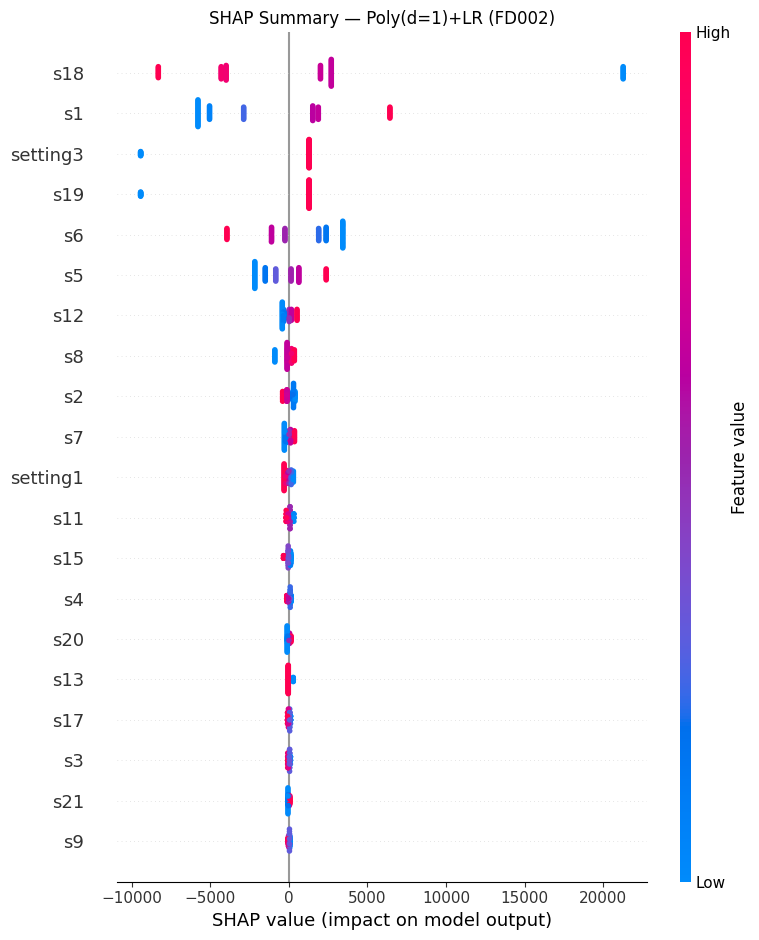

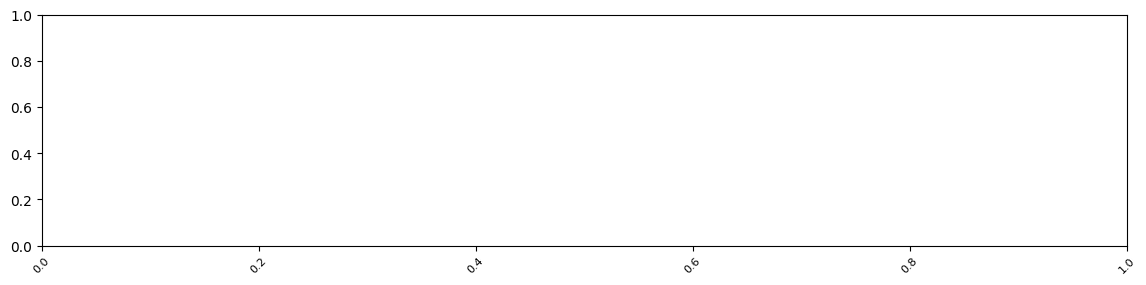

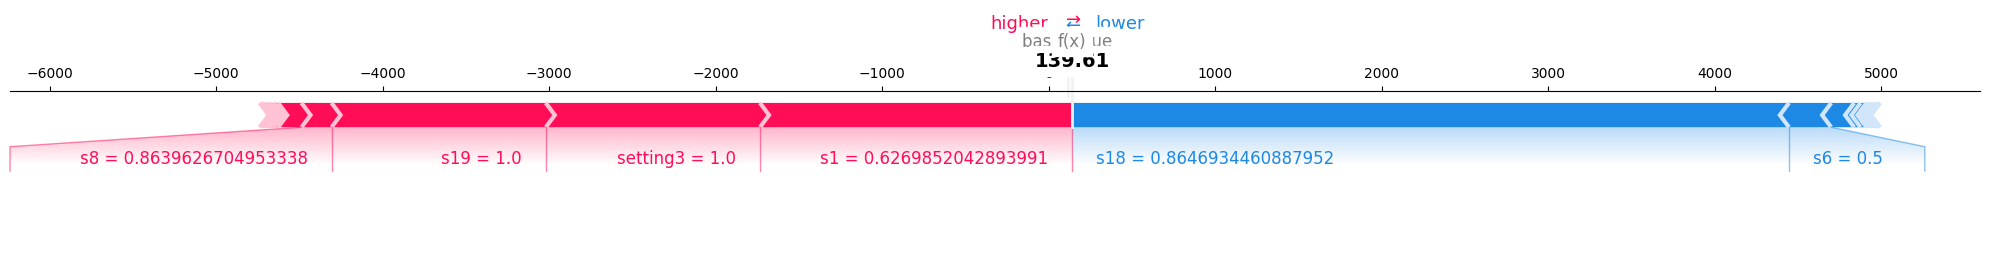

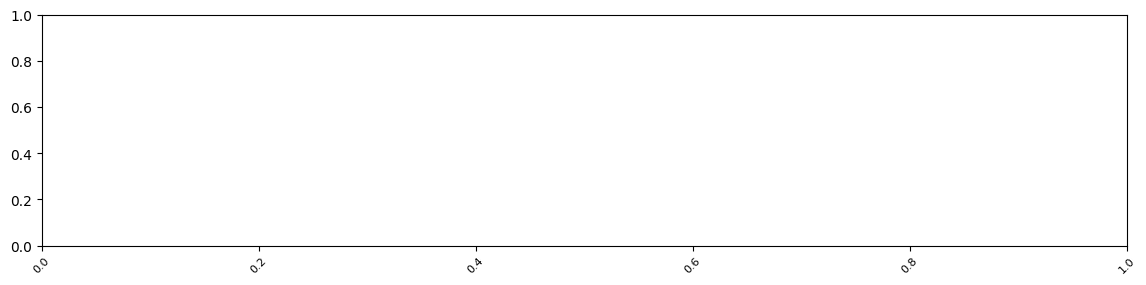

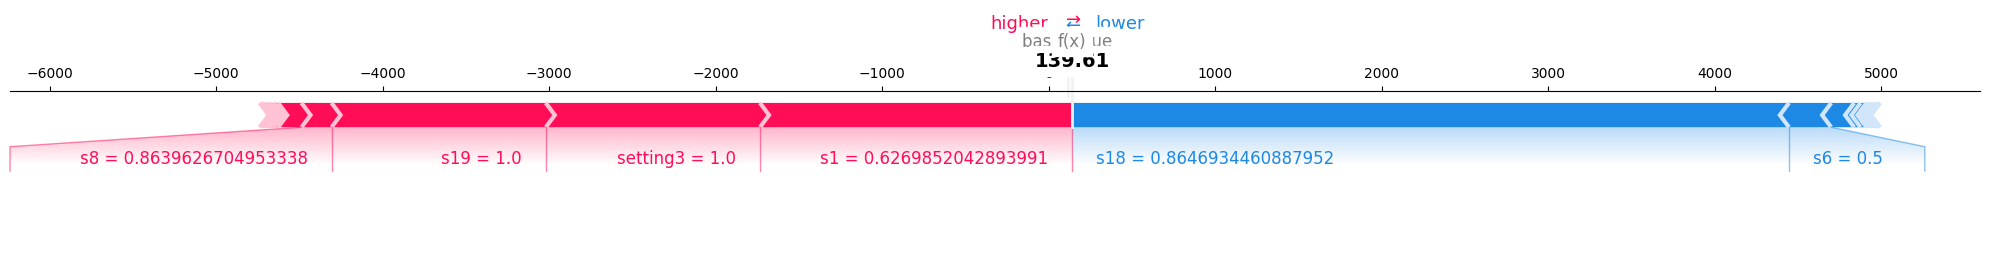

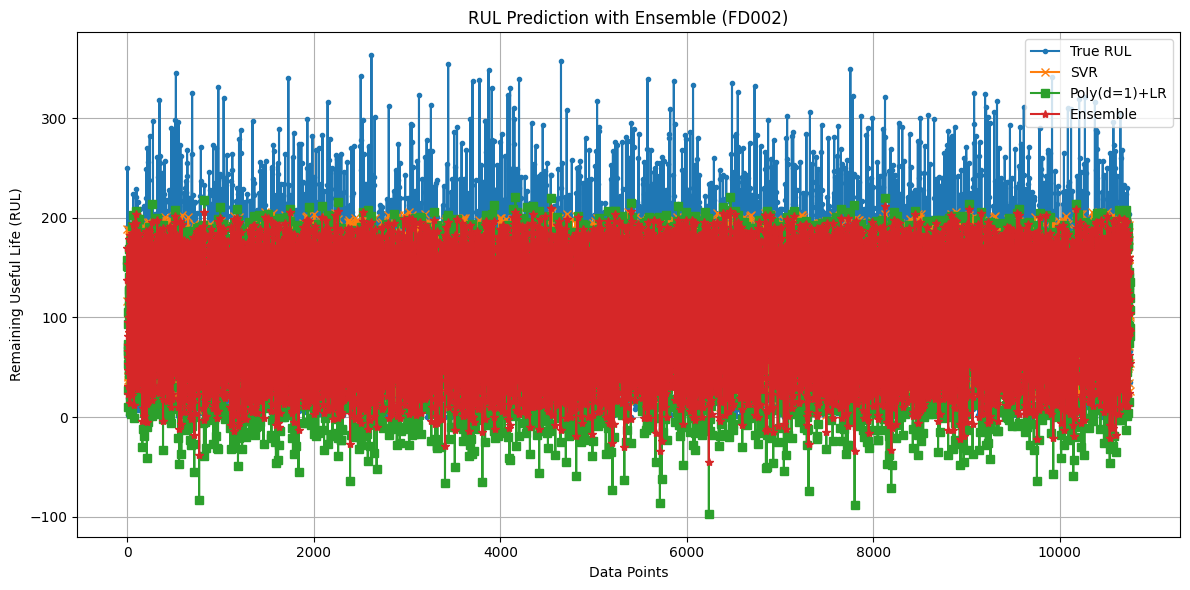



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (SVR) ---
Fold1: R2=0.6604, RMSE=40.5587, MAE=28.8094, PHM08_sum=53827570.4454, PHM08_avg=5004.8880
Fold2: R2=0.7063, RMSE=37.5518, MAE=26.8045, PHM08_sum=10870575.7727, PHM08_avg=1011.3104
Fold3: R2=0.6750, RMSE=39.2881, MAE=27.2532, PHM08_sum=23181839.7050, PHM08_avg=2155.8486
Fold4: R2=0.7263, RMSE=36.0547, MAE=25.8194, PHM08_sum=3800450.6466, PHM08_avg=353.4317
Fold5: R2=0.6640, RMSE=40.1013, MAE=29.2390, PHM08_sum=16933310.0122, PHM08_avg=1575.3382
Overall: R2=0.6863, RMSE=38.7473, MAE=27.5851, PHM08_sum=108613746.5820, PHM08_avg=2020.3826

--- GroupKFold (Poly(d=1)+LR) ---
Fold1: R2=0.6291, RMSE=42.3840, MAE=32.6640, PHM08_sum=52869894.9023, PHM08_avg=4915.8433
Fold2: R2=0.6649, RMSE=40.1156, MAE=31.5123, PHM08_sum=9940342.8346, PHM08_avg=924.7691

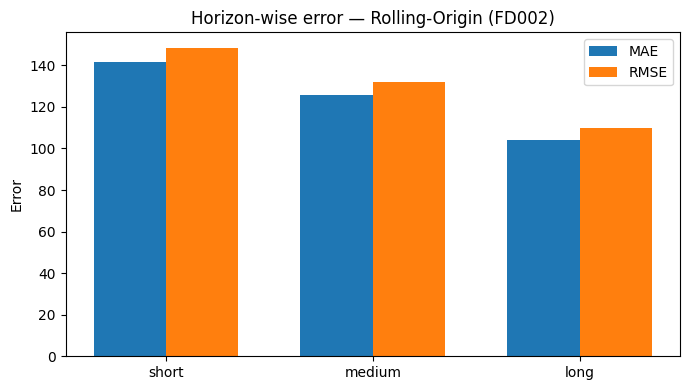

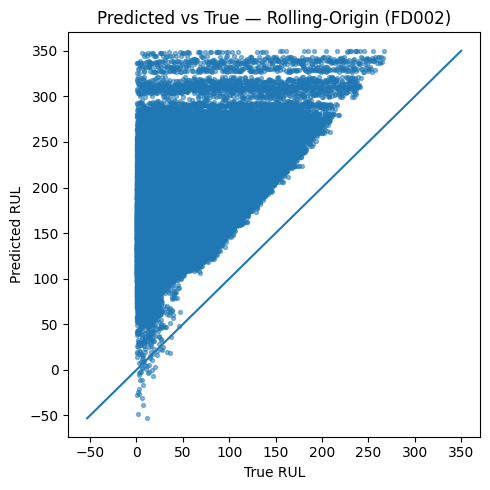


[PER-ENGINE MAE] (Top 10 worst engines)
112    202.693136
88     194.741468
85     185.655685
255    185.234079
118    184.474008
31     181.388724
158    168.645784
156    163.651716
153    163.107154
51     162.455191
dtype: float64


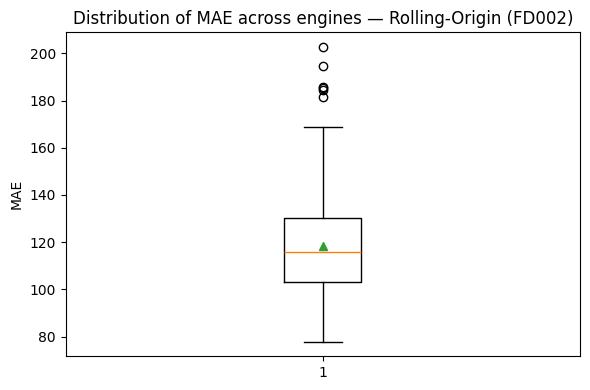

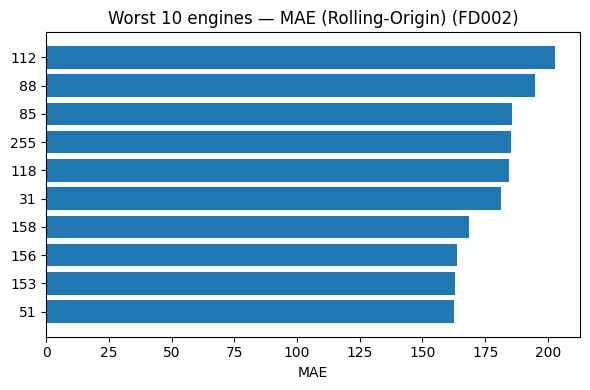


[ROLLING-ORIGIN OVERALL METRICS]
      R2: -9.1005
    RMSE: 132.1187
     MAE: 124.9550
 sMAPE_%: 117.3186

[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)
All features     : R²=0.6864 ± 0.0257
Without id/cycle : R²=0.5688 ± 0.0339


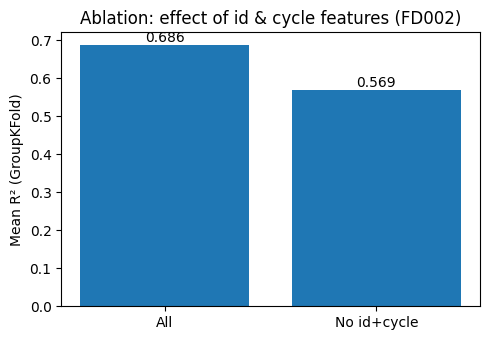


================ ROBUSTNESS ANALYSES COMPLETED ================


=== 80/20 SPLIT PROOF ===
Total samples : 53759
Train (80%)   : 43007  → ratio=0.8000
Test  (20%)   : 10752  → ratio=0.2000

=== RESOURCE USAGE REPORT ===
Elapsed time         : 3770.13 seconds
CPU% at start        : 6.4%   (~0.17 GHz)
CPU% at end          : 14.0%   (~0.36 GHz)
Memory at start      : 483.27 MB
Memory at end        : 655.71 MB   (Δ 172.44 MB)


In [5]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD002"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "svrpoly"

# Fixed model hyperparameters (as requested)
SVM_PARAMS = dict(
    C=500,
    epsilon=0.5,
    gamma='scale',
    kernel='rbf'
)

POLY_DEGREE = 1
LINEAR_PARAMS = dict(
    fit_intercept=True
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.base import clone
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

warnings.filterwarnings("ignore")

# ============================================
# Output paths — single, unified directory
# ============================================
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# ============================================
# Model training (SVR + Polynomial(1)+LinearRegression)
# ============================================
svr_model = SVR(**SVM_PARAMS)
svr_model.fit(X_train, y_train)
y_svr = svr_model.predict(X_val)

poly_model = Pipeline([
    ('poly', PolynomialFeatures(degree=POLY_DEGREE)),
    ('lin',  LinearRegression(**LINEAR_PARAMS))
])
poly_model.fit(X_train, y_train)
y_poly = poly_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_svr + 0.5 * y_poly

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_svr = print_block_metrics("SVR",         y_val, y_svr)
m_poly= print_block_metrics("Poly(d=1)+LR",y_val, y_poly)
m_ens = print_block_metrics("Ensemble",    y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_svr, m_poly, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations (fast & resilient)
# ============================================
FAST_SHAP_MAX_SECS = 120         # hard cap; if exceeded we skip SVR SHAP
SVR_NSAMPLES       = 60          # lower is faster; 50–100 reasonable
N_BG               = min(50, X_train.shape[0])
N_SUM              = min(80,  X_val.shape[0])

rng = np.random.default_rng(42)
bg_idx   = rng.choice(X_train.index, size=N_BG, replace=False)
X_bg_np  = X_train.loc[bg_idx].to_numpy(dtype=np.float32)
X_shap   = X_val.sample(n=N_SUM, random_state=42)
X_shap_np= X_shap.to_numpy(dtype=np.float32)
feature_names = X.columns.tolist()

# ---- SVR: KernelExplainer with tiny background + few evaluations
import time as _time
print("Computing SHAP (KernelExplainer) for SVR (fast mode)...")
_t0 = _time.time()
shap_vals_svr = None
try:
    svr_explainer = shap.KernelExplainer(lambda X_: svr_model.predict(np.asarray(X_, dtype=np.float32)),
                                         X_bg_np)
    shap_vals_svr = svr_explainer.shap_values(X_shap_np, nsamples=SVR_NSAMPLES, l1_reg="num_features(10)")
    if _time.time() - _t0 > FAST_SHAP_MAX_SECS:
        print("[INFO] SVR SHAP exceeded time cap; skipping SVR plots.")
        shap_vals_svr = None
except Exception as e:
    print(f"[WARN] SVR SHAP failed: {e}")
    shap_vals_svr = None

if shap_vals_svr is not None:
    shap.summary_plot(shap_vals_svr, X_shap, feature_names=feature_names, show=False)
    plt.title(f"SHAP Summary — SVR ({DATASET_NAME})")
    plt.tight_layout(); save_png(f"SHAP_Summary_SVR_{DATASET_NAME}.png"); plt.show()

# ---- Poly(d=1)+LR: exact & fast via LinearExplainer on pipeline internals
print("Computing SHAP (LinearExplainer) for Poly(d=1)+LR...")
poly_step = poly_model.named_steps['poly']
lin_step  = poly_model.named_steps['lin']

X_bg_poly   = poly_step.transform(X_bg_np)
X_shap_poly = poly_step.transform(X_shap_np)
poly_feat_names = list(poly_step.get_feature_names_out(input_features=feature_names))

lin_explainer  = shap.LinearExplainer(lin_step, X_bg_poly)
shap_vals_poly = lin_explainer.shap_values(X_shap_poly)

shap.summary_plot(shap_vals_poly, pd.DataFrame(X_shap_poly, columns=poly_feat_names),
                  feature_names=poly_feat_names, show=False)
plt.title(f"SHAP Summary — Poly(d=1)+LR ({DATASET_NAME})")
plt.tight_layout(); save_png(f"SHAP_Summary_PolyLR_{DATASET_NAME}.png"); plt.show()

# ---- Optional ensemble plot (only if SVR SHAP available & same dimensionality)
if shap_vals_svr is not None and np.shape(shap_vals_svr) == np.shape(shap_vals_poly):
    shap_vals_ens = (np.asarray(shap_vals_svr) + np.asarray(shap_vals_poly)) / 2.0
    shap.summary_plot(shap_vals_ens, X_shap, feature_names=feature_names, show=False)
    plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
    plt.tight_layout(); save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png"); plt.show()

# ---- Single-row force plots (guarded)
try:
    row = X_shap.iloc[[0]]
    f_row = row.iloc[0].values

    # SVR: use mean prediction over background as expected value
    if shap_vals_svr is not None:
        expected_svr = float(np.mean(svr_model.predict(X_bg_np)))
        sv_svr_row   = np.asarray(shap_vals_svr)[0]
        fig, ax = plt.subplots(figsize=(14, 3))
        _ = shap.force_plot(expected_svr, sv_svr_row, f_row,
                            feature_names=row.columns.tolist(), matplotlib=True, show=False)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        plt.tight_layout(); save_png(f"Local_SHAP_force_SVR_Single_{DATASET_NAME}.png"); plt.show()

    # Poly(d=1)+LR: expected via linear model on background (fast & exact)
    expected_poly = float(np.mean(lin_step.predict(X_bg_poly)))
    sv_poly_row   = np.asarray(shap_vals_poly)[0]
    row_poly      = poly_step.transform(row.values)[0]  # transformed feature vector
    fig, ax = plt.subplots(figsize=(14, 3))
    _ = shap.force_plot(expected_poly, sv_poly_row, row_poly,
                        feature_names=poly_feat_names, matplotlib=True, show=False)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    plt.tight_layout(); save_png(f"Local_SHAP_force_PolyLR_Single_{DATASET_NAME}.png"); plt.show()

    # Ensemble force plot only if dimensions match
    if shap_vals_svr is not None and len(sv_svr_row) == len(sv_poly_row):
        expected_ens = 0.5*expected_svr + 0.5*expected_poly
        sv_ens_row   = 0.5*sv_svr_row + 0.5*sv_poly_row
        fig, ax = plt.subplots(figsize=(14, 3))
        _ = shap.force_plot(expected_ens, sv_ens_row, f_row,
                            feature_names=row.columns.tolist(), matplotlib=True, show=False)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        plt.tight_layout(); save_png(f"Local_SHAP_force_Ensemble_Single_{DATASET_NAME}.png"); plt.show()

except Exception as e:
    print(f"[WARN] Local force plots skipped: {e}")


# Single-row force plots (SVR / Poly / Ensemble) — SAFE RE-RUN
# (Fix: use shap_vals_svr / shap_vals_poly; use row_poly for Poly; guard when SVR SHAP is None)
try:
    row = X_shap.iloc[[0]]
    f_row = row.iloc[0].values

    # SVR expected value & SHAP row (only if available)
    if shap_vals_svr is not None:
        expected_svr = float(np.mean(svr_model.predict(X_bg_np)))
        sv_svr_row   = np.asarray(shap_vals_svr)[0]
    else:
        expected_svr = None
        sv_svr_row   = None

    # Poly(d=1)+LR expected value & SHAP row (poly feature space!)
    expected_poly = float(np.mean(lin_step.predict(X_bg_poly)))
    sv_poly_row   = np.asarray(shap_vals_poly)[0]
    row_poly      = poly_step.transform(row.values)[0]  # transformed feature vector

    # --- Plot: SVR (only if SHAP for SVR was computed)
    if sv_svr_row is not None:
        fig, ax = plt.subplots(figsize=(14, 3))
        _ = shap.force_plot(expected_svr, sv_svr_row, f_row,
                            feature_names=row.columns.tolist(), matplotlib=True, show=False)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        plt.tight_layout()
        save_png(f"Local_SHAP_force_SVR_Single_{DATASET_NAME}.png")
        plt.show()

    # --- Plot: Poly(d=1)+LR (use polynomial features!)
    fig, ax = plt.subplots(figsize=(14, 3))
    _ = shap.force_plot(expected_poly, sv_poly_row, row_poly,
                        feature_names=poly_feat_names, matplotlib=True, show=False)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    plt.tight_layout()
    save_png(f"Local_SHAP_force_PolyLR_Single_{DATASET_NAME}.png")
    plt.show()

    # --- Plot: Ensemble (only if both SHAP vectors align)
    if sv_svr_row is not None and len(sv_svr_row) == len(sv_poly_row):
        expected_ens = 0.5*expected_svr + 0.5*expected_poly
        sv_ens_row   = 0.5*sv_svr_row + 0.5*sv_poly_row
        fig, ax = plt.subplots(figsize=(14, 3))
        _ = shap.force_plot(expected_ens, sv_ens_row, f_row,
                            feature_names=row.columns.tolist(), matplotlib=True, show=False)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        plt.tight_layout()
        save_png(f"Local_SHAP_force_Ensemble_Single_{DATASET_NAME}.png")
        plt.show()

except Exception as e:
    print(f"[WARN] Local force plots (second pass) skipped: {e}")

# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_svr)),      y_svr,          label="SVR",       marker='x')
plt.plot(range(len(y_poly)),     y_poly,         label="Poly(d=1)+LR", marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",  marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

# Config & helpers
W = 30
H = 1
EMBARGO = 10
N_SPLITS = 5

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaling
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_svr = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", SVR(**SVM_PARAMS))
])
pipe_poly = Pipeline([
    ("scaler", MinMaxScaler()),
    ("poly", PolynomialFeatures(degree=POLY_DEGREE)),
    ("lin", LinearRegression(**LINEAR_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
_ = cv_eval_pipeline(X, y, groups, pipe_svr,  name="SVR")
_ = cv_eval_pipeline(X, y, groups, pipe_poly, name="Poly(d=1)+LR")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_svr():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", SVR(**SVM_PARAMS))
    ])

def build_pipe_poly():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("poly", PolynomialFeatures(degree=POLY_DEGREE)),
        ("lin", LinearRegression(**LINEAR_PARAMS))
    ])

_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_svr, name="SVR"
)
_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_poly, name="Poly(d=1)+LR"
)

# ============================================
# A/B leakage diagnostics
# ============================================
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", SVR(**SVM_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", SVR(**SVM_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_svr, name="SVR")
_ = cv_eval_pipeline(X, y, groups, build_pipe_svr(), name="SVR (GroupKFold)")

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_svr,
    embargo_val=0,  name=f"Rolling-Origin SVR (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_svr,
    embargo_val=10, name=f"Rolling-Origin SVR (Embargo=10, {DATASET_NAME})"
)

# ============================================
# Permutation (Null) Test
# ============================================
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_svr, n_iters=1
)

# ============================================
# Horizon-wise error profile & plots
# ============================================
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_svr
)

if hy is not None:
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": horizon_bins(pd.Series(hy))})
    met = (dfm.groupby("bin", dropna=False)
             .apply(lambda g: pd.Series({
                 "MAE": mean_absolute_error(g["y"], g["p"]),
                 "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
                 "R2": r2_score(g["y"], g["p"])
             }))
          ).reset_index()
    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met)); w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    lo = float(min(np.min(hy), np.min(hp))); hi = float(max(np.max(hy), np.max(hp)))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# ============================================
# Per-engine error distribution
# ============================================
def rolling_origin_engine_errors(df_all, features, model_builder):
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_svr
)

if per_engine:
    mae_series = pd.Series(
        {eid: np.mean(v) for eid, v in per_engine.items()}
    ).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# ============================================
# sMAPE + overall rolling-origin metrics
# ============================================
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# ============================================
# Ablation: effect of including id & cycle
# ============================================
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_svr)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_svr)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")



SVR Performance:
  R^2 Score:           0.4152
  Mean Squared Error:  5731.3352
  Mean Absolute Error: 48.3547
  PHM08 Score (sum):   295709229539.8616
  PHM08 Score (avg):   59811737.3665

Poly(d=1)+LR Performance:
  R^2 Score:           0.6251
  Mean Squared Error:  3674.5476
  Mean Absolute Error: 44.8470
  PHM08 Score (sum):   1902096303570.8611
  PHM08 Score (avg):   384728216.7417

Ensemble Performance:
  R^2 Score:           0.5936
  Mean Squared Error:  3982.8765
  Mean Absolute Error: 42.6429
  PHM08 Score (sum):   24038445520.3682
  PHM08 Score (avg):   4862145.1295
Computing SHAP (KernelExplainer) for SVR (fast mode)...


  0%|          | 0/80 [00:00<?, ?it/s]

[INFO] SVR SHAP exceeded time cap; skipping SVR plots.
Computing SHAP (LinearExplainer) for Poly(d=1)+LR...


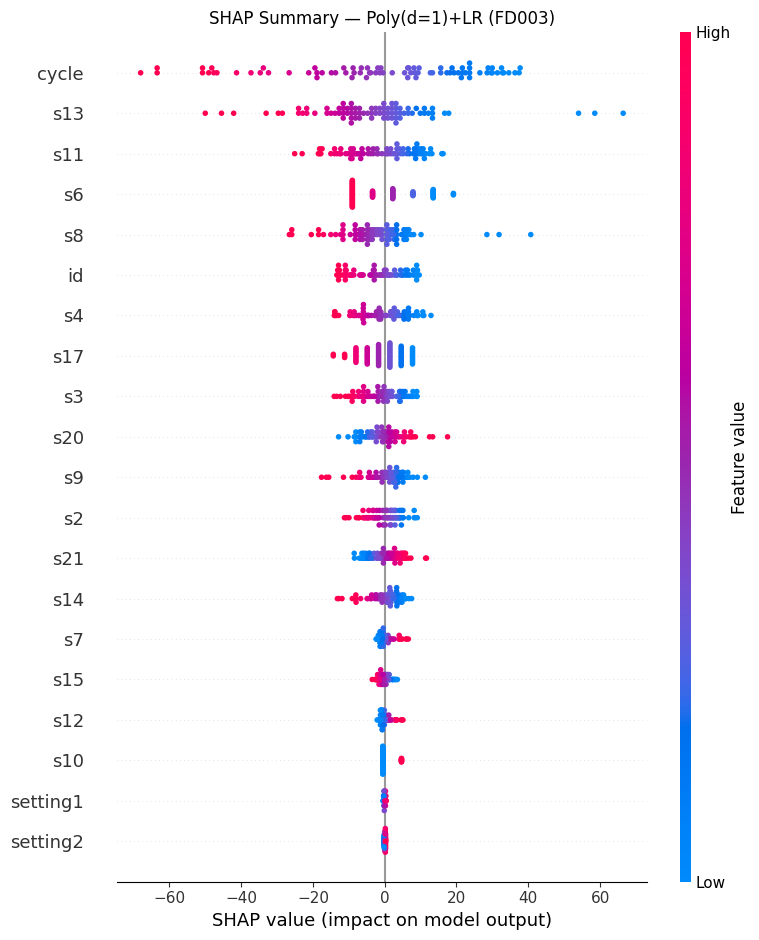

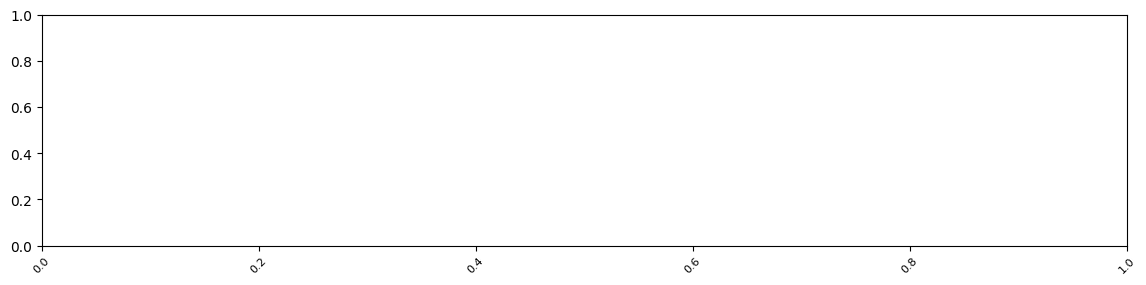

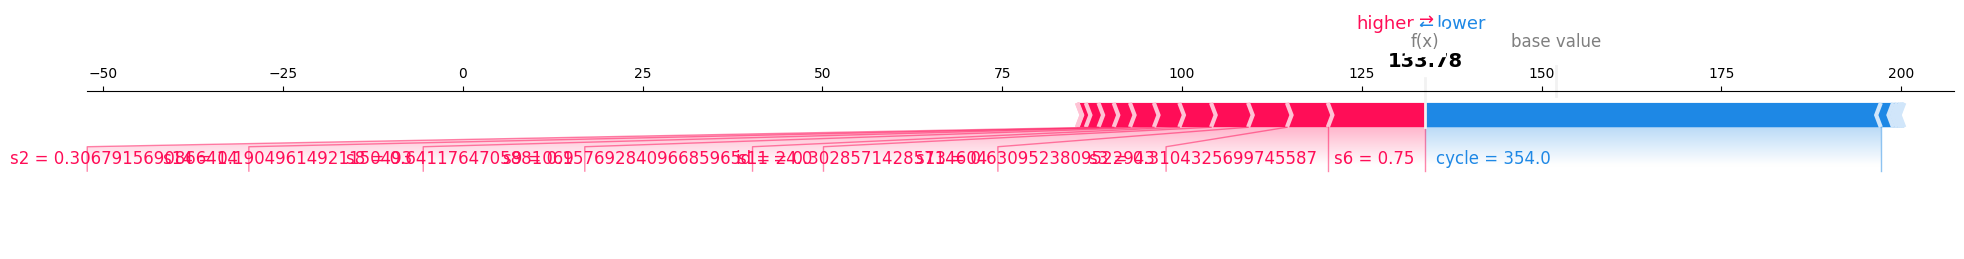

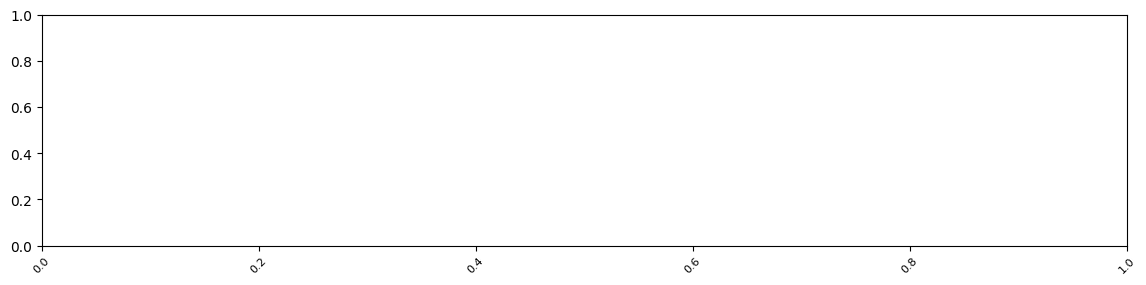

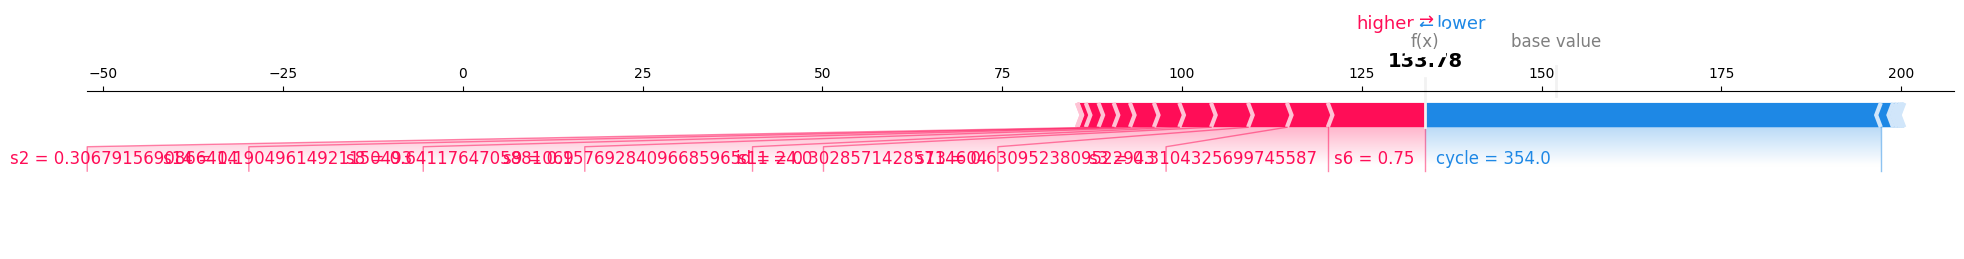

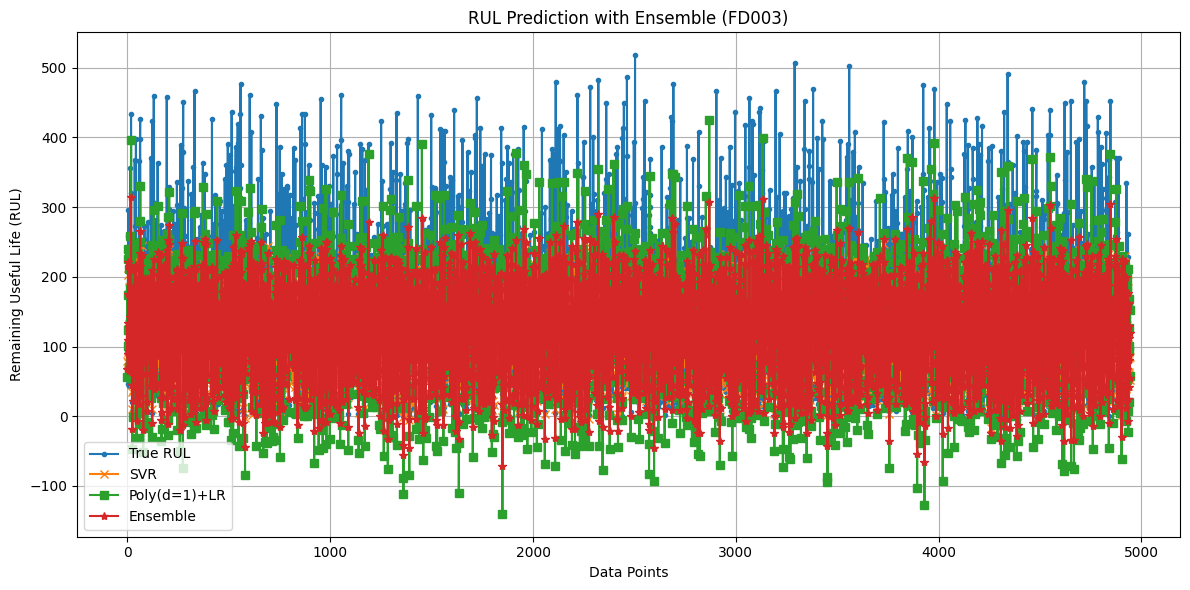



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (SVR) ---
Fold1: R2=0.5541, RMSE=67.6505, MAE=46.4484, PHM08_sum=764741126246.3462, PHM08_avg=154743246.9135
Fold2: R2=0.7670, RMSE=47.6153, MAE=30.5023, PHM08_sum=134498864.7385, PHM08_avg=27193.4623
Fold3: R2=0.5775, RMSE=63.9267, MAE=42.6899, PHM08_sum=106670275795.2679, PHM08_avg=21566978.5271
Fold4: R2=0.4940, RMSE=69.8178, MAE=43.6912, PHM08_sum=2226194497300238.0000, PHM08_avg=450646659372.5178
Fold5: R2=0.4607, RMSE=71.7620, MAE=50.1142, PHM08_sum=283531868905365.3750, PHM08_avg=57325489062.9530
Overall: R2=0.5711, RMSE=64.7358, MAE=42.6884, PHM08_sum=2510597912106509.5000, PHM08_avg=101561404211.4284

--- GroupKFold (Poly(d=1)+LR) ---
Fold1: R2=0.5445, RMSE=68.3774, MAE=52.7140, PHM08_sum=8949959166.0543, PHM08_avg=1810999.4266
Fold2: R2=0.6854

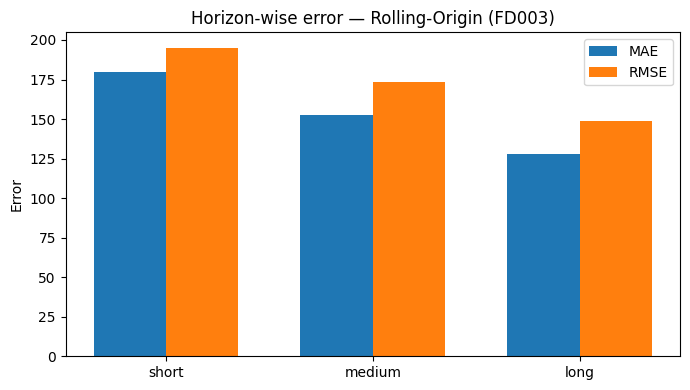

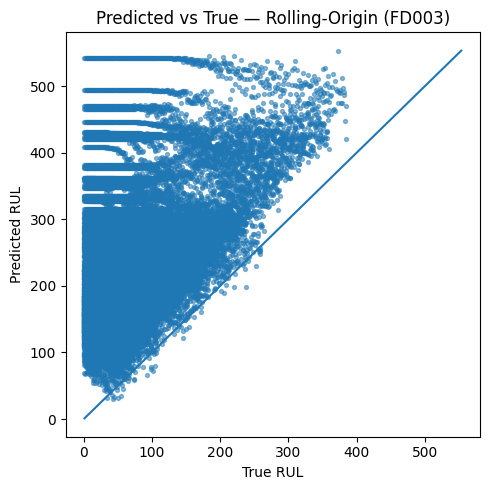


[PER-ENGINE MAE] (Top 10 worst engines)
55    280.764330
34    250.900825
10    244.794568
96    231.142772
18    219.090579
24    214.368758
9     210.415905
71    209.484268
94    207.349199
7     183.268803
dtype: float64


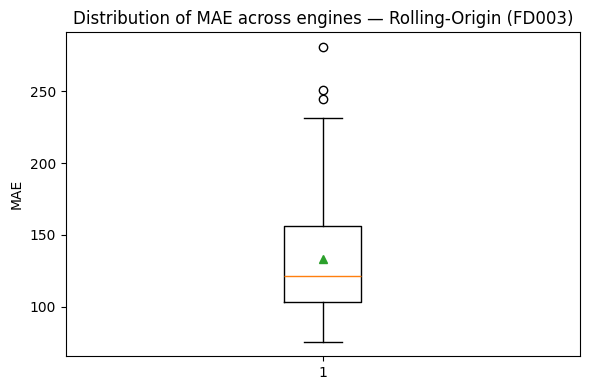

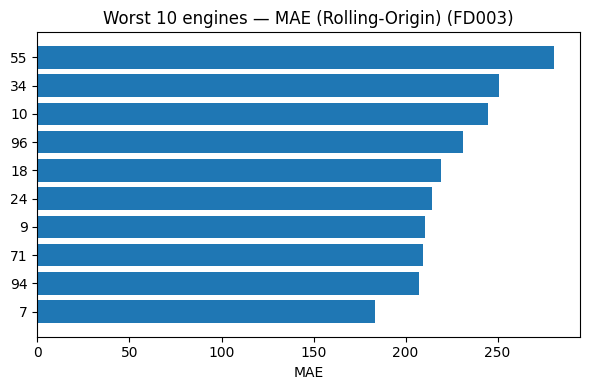


[ROLLING-ORIGIN OVERALL METRICS]
      R2: -6.3495
    RMSE: 170.4553
     MAE: 150.1395
 sMAPE_%: 110.5731

[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)
All features     : R²=0.5707 ± 0.1066
Without id/cycle : R²=0.6142 ± 0.0601


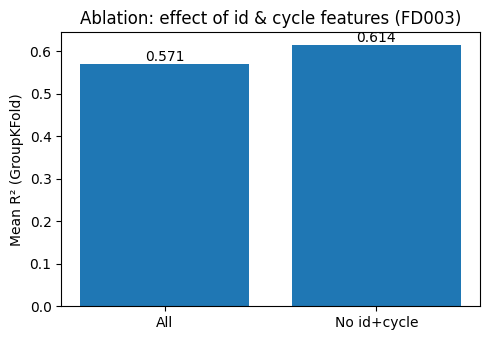


================ ROBUSTNESS ANALYSES COMPLETED ================


=== 80/20 SPLIT PROOF ===
Total samples : 24720
Train (80%)   : 19776  → ratio=0.8000
Test  (20%)   : 4944  → ratio=0.2000

=== RESOURCE USAGE REPORT ===
Elapsed time         : 1229.25 seconds
CPU% at start        : 5.0%   (~0.13 GHz)
CPU% at end          : 14.9%   (~0.39 GHz)
Memory at start      : 656.48 MB
Memory at end        : 633.48 MB   (Δ -23.00 MB)


In [6]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD003"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "svrpoly"

# Fixed model hyperparameters (as requested)
SVM_PARAMS = dict(
    C=500,
    epsilon=0.5,
    gamma='scale',
    kernel='rbf'
)

POLY_DEGREE = 1
LINEAR_PARAMS = dict(
    fit_intercept=True
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.base import clone
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

warnings.filterwarnings("ignore")

# ============================================
# Output paths — single, unified directory
# ============================================
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# ============================================
# Model training (SVR + Polynomial(1)+LinearRegression)
# ============================================
svr_model = SVR(**SVM_PARAMS)
svr_model.fit(X_train, y_train)
y_svr = svr_model.predict(X_val)

poly_model = Pipeline([
    ('poly', PolynomialFeatures(degree=POLY_DEGREE)),
    ('lin',  LinearRegression(**LINEAR_PARAMS))
])
poly_model.fit(X_train, y_train)
y_poly = poly_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_svr + 0.5 * y_poly

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_svr = print_block_metrics("SVR",         y_val, y_svr)
m_poly= print_block_metrics("Poly(d=1)+LR",y_val, y_poly)
m_ens = print_block_metrics("Ensemble",    y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_svr, m_poly, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations (fast & resilient)
# ============================================
FAST_SHAP_MAX_SECS = 120         # hard cap; if exceeded we skip SVR SHAP
SVR_NSAMPLES       = 60          # lower is faster; 50–100 reasonable
N_BG               = min(50, X_train.shape[0])
N_SUM              = min(80,  X_val.shape[0])

rng = np.random.default_rng(42)
bg_idx   = rng.choice(X_train.index, size=N_BG, replace=False)
X_bg_np  = X_train.loc[bg_idx].to_numpy(dtype=np.float32)
X_shap   = X_val.sample(n=N_SUM, random_state=42)
X_shap_np= X_shap.to_numpy(dtype=np.float32)
feature_names = X.columns.tolist()

# ---- SVR: KernelExplainer with tiny background + few evaluations
import time as _time
print("Computing SHAP (KernelExplainer) for SVR (fast mode)...")
_t0 = _time.time()
shap_vals_svr = None
try:
    svr_explainer = shap.KernelExplainer(lambda X_: svr_model.predict(np.asarray(X_, dtype=np.float32)),
                                         X_bg_np)
    shap_vals_svr = svr_explainer.shap_values(X_shap_np, nsamples=SVR_NSAMPLES, l1_reg="num_features(10)")
    if _time.time() - _t0 > FAST_SHAP_MAX_SECS:
        print("[INFO] SVR SHAP exceeded time cap; skipping SVR plots.")
        shap_vals_svr = None
except Exception as e:
    print(f"[WARN] SVR SHAP failed: {e}")
    shap_vals_svr = None

if shap_vals_svr is not None:
    shap.summary_plot(shap_vals_svr, X_shap, feature_names=feature_names, show=False)
    plt.title(f"SHAP Summary — SVR ({DATASET_NAME})")
    plt.tight_layout(); save_png(f"SHAP_Summary_SVR_{DATASET_NAME}.png"); plt.show()

# ---- Poly(d=1)+LR: exact & fast via LinearExplainer on pipeline internals
print("Computing SHAP (LinearExplainer) for Poly(d=1)+LR...")
poly_step = poly_model.named_steps['poly']
lin_step  = poly_model.named_steps['lin']

X_bg_poly   = poly_step.transform(X_bg_np)
X_shap_poly = poly_step.transform(X_shap_np)
poly_feat_names = list(poly_step.get_feature_names_out(input_features=feature_names))

lin_explainer  = shap.LinearExplainer(lin_step, X_bg_poly)
shap_vals_poly = lin_explainer.shap_values(X_shap_poly)

shap.summary_plot(shap_vals_poly, pd.DataFrame(X_shap_poly, columns=poly_feat_names),
                  feature_names=poly_feat_names, show=False)
plt.title(f"SHAP Summary — Poly(d=1)+LR ({DATASET_NAME})")
plt.tight_layout(); save_png(f"SHAP_Summary_PolyLR_{DATASET_NAME}.png"); plt.show()

# ---- Optional ensemble plot (only if SVR SHAP available & same dimensionality)
if shap_vals_svr is not None and np.shape(shap_vals_svr) == np.shape(shap_vals_poly):
    shap_vals_ens = (np.asarray(shap_vals_svr) + np.asarray(shap_vals_poly)) / 2.0
    shap.summary_plot(shap_vals_ens, X_shap, feature_names=feature_names, show=False)
    plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
    plt.tight_layout(); save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png"); plt.show()

# ---- Single-row force plots (guarded)
try:
    row = X_shap.iloc[[0]]
    f_row = row.iloc[0].values

    # SVR: use mean prediction over background as expected value
    if shap_vals_svr is not None:
        expected_svr = float(np.mean(svr_model.predict(X_bg_np)))
        sv_svr_row   = np.asarray(shap_vals_svr)[0]
        fig, ax = plt.subplots(figsize=(14, 3))
        _ = shap.force_plot(expected_svr, sv_svr_row, f_row,
                            feature_names=row.columns.tolist(), matplotlib=True, show=False)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        plt.tight_layout(); save_png(f"Local_SHAP_force_SVR_Single_{DATASET_NAME}.png"); plt.show()

    # Poly(d=1)+LR: expected via linear model on background (fast & exact)
    expected_poly = float(np.mean(lin_step.predict(X_bg_poly)))
    sv_poly_row   = np.asarray(shap_vals_poly)[0]
    row_poly      = poly_step.transform(row.values)[0]  # transformed feature vector
    fig, ax = plt.subplots(figsize=(14, 3))
    _ = shap.force_plot(expected_poly, sv_poly_row, row_poly,
                        feature_names=poly_feat_names, matplotlib=True, show=False)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    plt.tight_layout(); save_png(f"Local_SHAP_force_PolyLR_Single_{DATASET_NAME}.png"); plt.show()

    # Ensemble force plot only if dimensions match
    if shap_vals_svr is not None and len(sv_svr_row) == len(sv_poly_row):
        expected_ens = 0.5*expected_svr + 0.5*expected_poly
        sv_ens_row   = 0.5*sv_svr_row + 0.5*sv_poly_row
        fig, ax = plt.subplots(figsize=(14, 3))
        _ = shap.force_plot(expected_ens, sv_ens_row, f_row,
                            feature_names=row.columns.tolist(), matplotlib=True, show=False)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        plt.tight_layout(); save_png(f"Local_SHAP_force_Ensemble_Single_{DATASET_NAME}.png"); plt.show()

except Exception as e:
    print(f"[WARN] Local force plots skipped: {e}")


# Single-row force plots (SVR / Poly / Ensemble) — SAFE RE-RUN
# (Fix: use shap_vals_svr / shap_vals_poly; use row_poly for Poly; guard when SVR SHAP is None)
try:
    row = X_shap.iloc[[0]]
    f_row = row.iloc[0].values

    # SVR expected value & SHAP row (only if available)
    if shap_vals_svr is not None:
        expected_svr = float(np.mean(svr_model.predict(X_bg_np)))
        sv_svr_row   = np.asarray(shap_vals_svr)[0]
    else:
        expected_svr = None
        sv_svr_row   = None

    # Poly(d=1)+LR expected value & SHAP row (poly feature space!)
    expected_poly = float(np.mean(lin_step.predict(X_bg_poly)))
    sv_poly_row   = np.asarray(shap_vals_poly)[0]
    row_poly      = poly_step.transform(row.values)[0]  # transformed feature vector

    # --- Plot: SVR (only if SHAP for SVR was computed)
    if sv_svr_row is not None:
        fig, ax = plt.subplots(figsize=(14, 3))
        _ = shap.force_plot(expected_svr, sv_svr_row, f_row,
                            feature_names=row.columns.tolist(), matplotlib=True, show=False)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        plt.tight_layout()
        save_png(f"Local_SHAP_force_SVR_Single_{DATASET_NAME}.png")
        plt.show()

    # --- Plot: Poly(d=1)+LR (use polynomial features!)
    fig, ax = plt.subplots(figsize=(14, 3))
    _ = shap.force_plot(expected_poly, sv_poly_row, row_poly,
                        feature_names=poly_feat_names, matplotlib=True, show=False)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    plt.tight_layout()
    save_png(f"Local_SHAP_force_PolyLR_Single_{DATASET_NAME}.png")
    plt.show()

    # --- Plot: Ensemble (only if both SHAP vectors align)
    if sv_svr_row is not None and len(sv_svr_row) == len(sv_poly_row):
        expected_ens = 0.5*expected_svr + 0.5*expected_poly
        sv_ens_row   = 0.5*sv_svr_row + 0.5*sv_poly_row
        fig, ax = plt.subplots(figsize=(14, 3))
        _ = shap.force_plot(expected_ens, sv_ens_row, f_row,
                            feature_names=row.columns.tolist(), matplotlib=True, show=False)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        plt.tight_layout()
        save_png(f"Local_SHAP_force_Ensemble_Single_{DATASET_NAME}.png")
        plt.show()

except Exception as e:
    print(f"[WARN] Local force plots (second pass) skipped: {e}")

# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_svr)),      y_svr,          label="SVR",       marker='x')
plt.plot(range(len(y_poly)),     y_poly,         label="Poly(d=1)+LR", marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",  marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

# Config & helpers
W = 30
H = 1
EMBARGO = 10
N_SPLITS = 5

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaling
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_svr = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", SVR(**SVM_PARAMS))
])
pipe_poly = Pipeline([
    ("scaler", MinMaxScaler()),
    ("poly", PolynomialFeatures(degree=POLY_DEGREE)),
    ("lin", LinearRegression(**LINEAR_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
_ = cv_eval_pipeline(X, y, groups, pipe_svr,  name="SVR")
_ = cv_eval_pipeline(X, y, groups, pipe_poly, name="Poly(d=1)+LR")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_svr():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", SVR(**SVM_PARAMS))
    ])

def build_pipe_poly():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("poly", PolynomialFeatures(degree=POLY_DEGREE)),
        ("lin", LinearRegression(**LINEAR_PARAMS))
    ])

_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_svr, name="SVR"
)
_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_poly, name="Poly(d=1)+LR"
)

# ============================================
# A/B leakage diagnostics
# ============================================
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", SVR(**SVM_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", SVR(**SVM_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_svr, name="SVR")
_ = cv_eval_pipeline(X, y, groups, build_pipe_svr(), name="SVR (GroupKFold)")

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_svr,
    embargo_val=0,  name=f"Rolling-Origin SVR (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_svr,
    embargo_val=10, name=f"Rolling-Origin SVR (Embargo=10, {DATASET_NAME})"
)

# ============================================
# Permutation (Null) Test
# ============================================
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_svr, n_iters=1
)

# ============================================
# Horizon-wise error profile & plots
# ============================================
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_svr
)

if hy is not None:
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": horizon_bins(pd.Series(hy))})
    met = (dfm.groupby("bin", dropna=False)
             .apply(lambda g: pd.Series({
                 "MAE": mean_absolute_error(g["y"], g["p"]),
                 "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
                 "R2": r2_score(g["y"], g["p"])
             }))
          ).reset_index()
    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met)); w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    lo = float(min(np.min(hy), np.min(hp))); hi = float(max(np.max(hy), np.max(hp)))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# ============================================
# Per-engine error distribution
# ============================================
def rolling_origin_engine_errors(df_all, features, model_builder):
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_svr
)

if per_engine:
    mae_series = pd.Series(
        {eid: np.mean(v) for eid, v in per_engine.items()}
    ).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# ============================================
# sMAPE + overall rolling-origin metrics
# ============================================
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# ============================================
# Ablation: effect of including id & cycle
# ============================================
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_svr)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_svr)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")



SVR Performance:
  R^2 Score:           0.4152
  Mean Squared Error:  4702.1223
  Mean Absolute Error: 51.9143
  PHM08 Score (sum):   616829278504.8711
  PHM08 Score (avg):   50353410.4902

Poly(d=1)+LR Performance:
  R^2 Score:           0.6127
  Mean Squared Error:  3114.1398
  Mean Absolute Error: 42.7315
  PHM08 Score (sum):   279849493125.8331
  PHM08 Score (avg):   22844856.5817

Ensemble Performance:
  R^2 Score:           0.5912
  Mean Squared Error:  3287.0105
  Mean Absolute Error: 42.6799
  PHM08 Score (sum):   243248691194.3130
  PHM08 Score (avg):   19857036.0159
Computing SHAP (KernelExplainer) for SVR (fast mode)...


  0%|          | 0/80 [00:00<?, ?it/s]

[INFO] SVR SHAP exceeded time cap; skipping SVR plots.
Computing SHAP (LinearExplainer) for Poly(d=1)+LR...


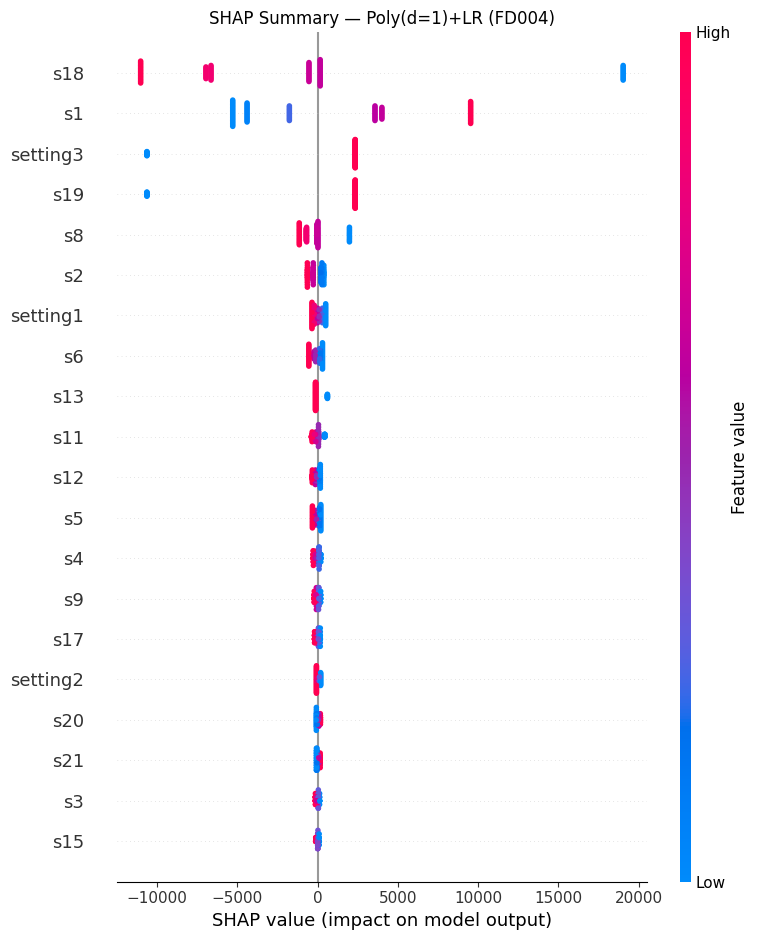

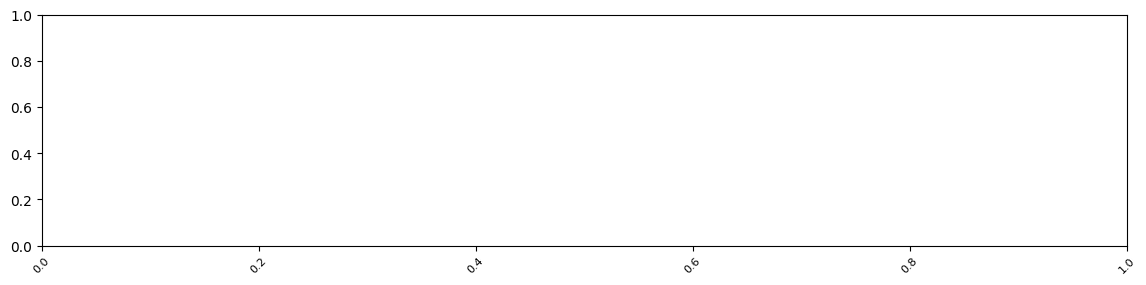

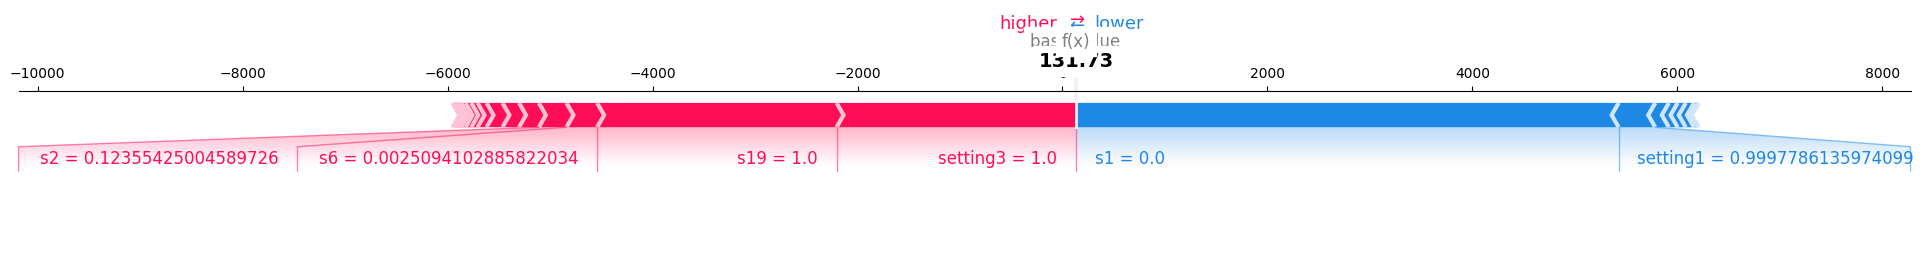

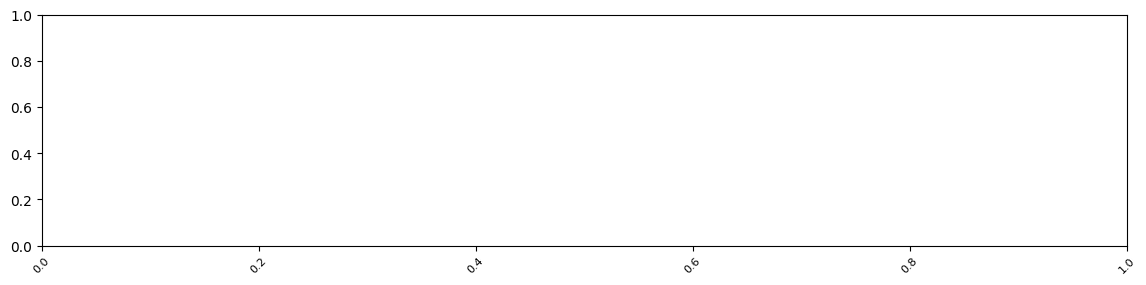

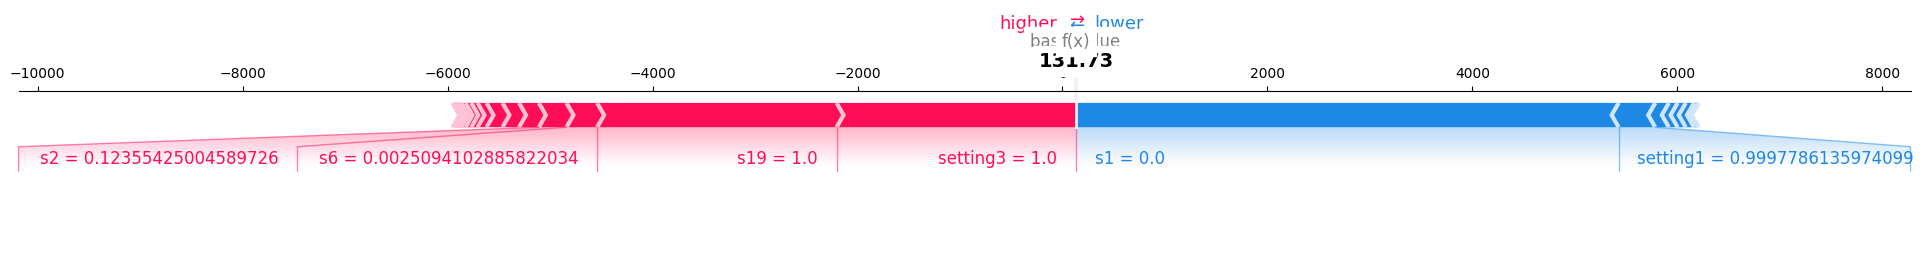

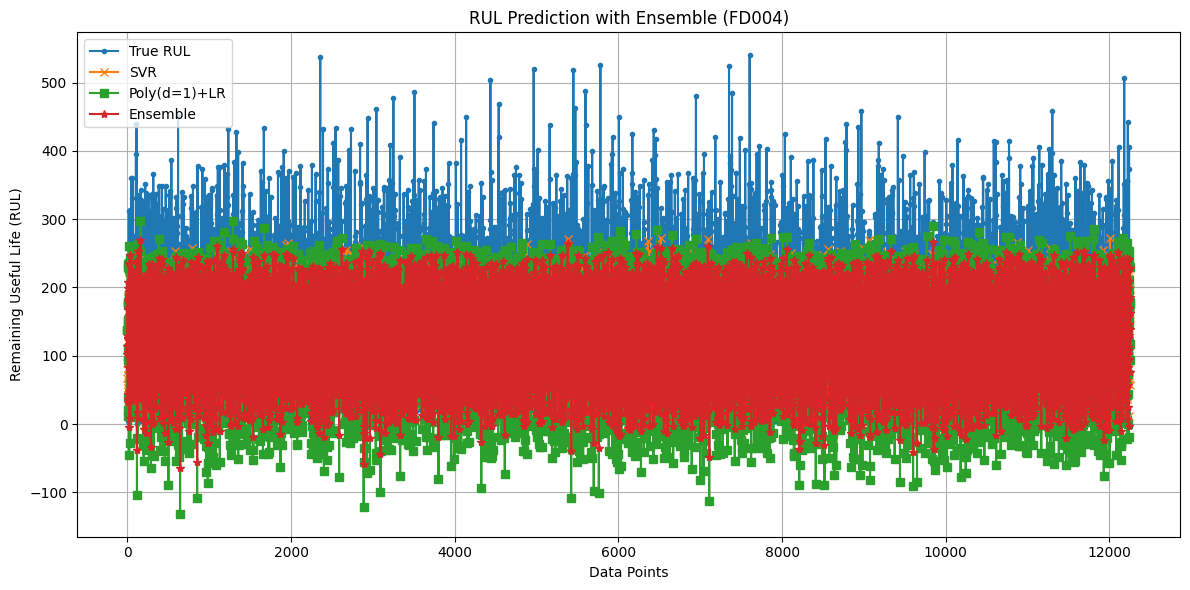



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (SVR) ---
Fold1: R2=0.5750, RMSE=60.4700, MAE=41.5285, PHM08_sum=949529087882.3086, PHM08_avg=77323215.6256
Fold2: R2=0.6890, RMSE=50.1451, MAE=35.5941, PHM08_sum=3326776652.0102, PHM08_avg=273898.9504
Fold3: R2=0.6505, RMSE=52.5533, MAE=38.5973, PHM08_sum=204691215.7813, PHM08_avg=16678.1729
Fold4: R2=0.6659, RMSE=51.2373, MAE=37.4488, PHM08_sum=439089731.4110, PHM08_avg=35773.9719
Fold5: R2=0.6777, RMSE=50.3079, MAE=35.8811, PHM08_sum=360644340.8751, PHM08_avg=29378.0010
Overall: R2=0.6503, RMSE=53.0899, MAE=37.8149, PHM08_sum=953860289822.3861, PHM08_avg=15573483.4825

--- GroupKFold (Poly(d=1)+LR) ---
Fold1: R2=0.5167, RMSE=64.4872, MAE=47.7570, PHM08_sum=1212176840621.4155, PHM08_avg=98711469.1060
Fold2: R2=0.6472, RMSE=53.4077, MAE=40.7038, PHM08_

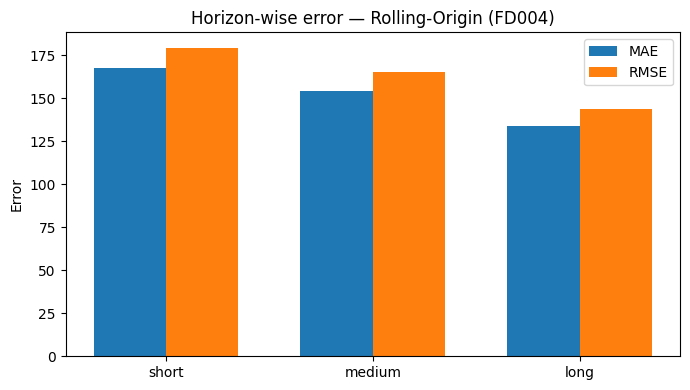

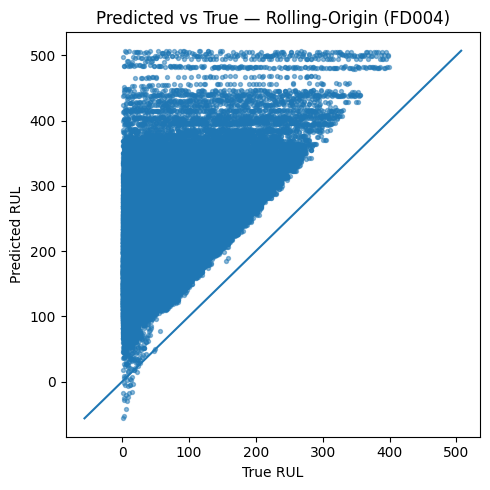


[PER-ENGINE MAE] (Top 10 worst engines)
118    280.129195
133    246.799876
173    238.126393
49     231.236746
179    220.825247
225    219.615894
171    212.483412
158    211.901330
37     204.581000
207    203.051555
dtype: float64


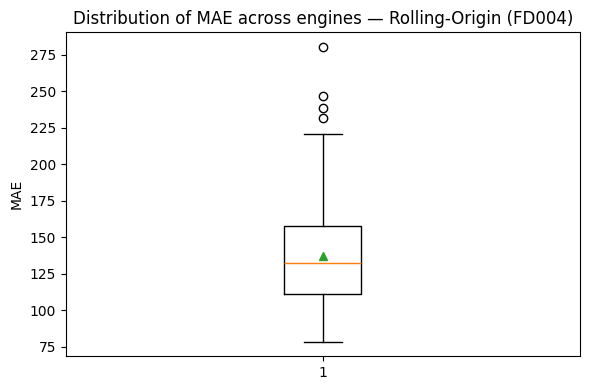

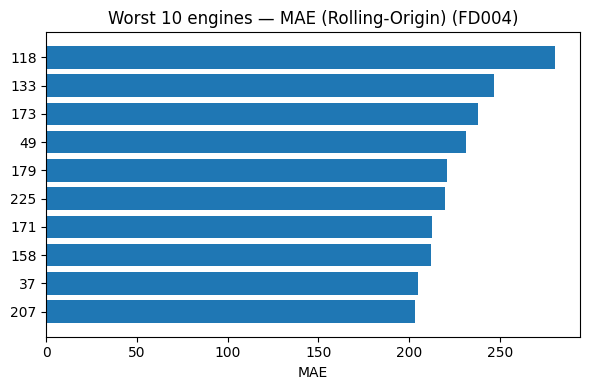


[ROLLING-ORIGIN OVERALL METRICS]
      R2: -7.2566
    RMSE: 161.5174
     MAE: 149.9991
 sMAPE_%: 114.4291

[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)
All features     : R²=0.6516 ± 0.0404
Without id/cycle : R²=0.5283 ± 0.0364


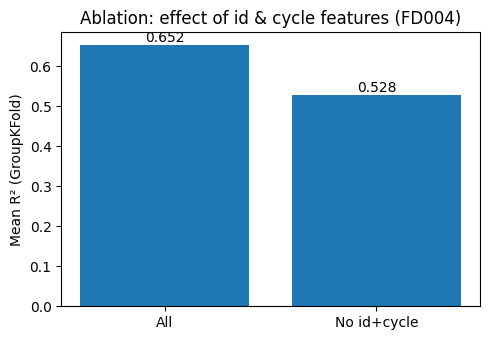


================ ROBUSTNESS ANALYSES COMPLETED ================


=== 80/20 SPLIT PROOF ===
Total samples : 61249
Train (80%)   : 48999  → ratio=0.8000
Test  (20%)   : 12250  → ratio=0.2000

=== RESOURCE USAGE REPORT ===
Elapsed time         : 4932.20 seconds
CPU% at start        : 2.1%   (~0.05 GHz)
CPU% at end          : 13.6%   (~0.35 GHz)
Memory at start      : 633.48 MB
Memory at end        : 650.01 MB   (Δ 16.53 MB)


In [7]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD004"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "svrpoly"

# Fixed model hyperparameters (as requested)
SVM_PARAMS = dict(
    C=500,
    epsilon=0.5,
    gamma='scale',
    kernel='rbf'
)

POLY_DEGREE = 1
LINEAR_PARAMS = dict(
    fit_intercept=True
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.base import clone
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

warnings.filterwarnings("ignore")

# ============================================
# Output paths — single, unified directory
# ============================================
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# ============================================
# Model training (SVR + Polynomial(1)+LinearRegression)
# ============================================
svr_model = SVR(**SVM_PARAMS)
svr_model.fit(X_train, y_train)
y_svr = svr_model.predict(X_val)

poly_model = Pipeline([
    ('poly', PolynomialFeatures(degree=POLY_DEGREE)),
    ('lin',  LinearRegression(**LINEAR_PARAMS))
])
poly_model.fit(X_train, y_train)
y_poly = poly_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_svr + 0.5 * y_poly

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_svr = print_block_metrics("SVR",         y_val, y_svr)
m_poly= print_block_metrics("Poly(d=1)+LR",y_val, y_poly)
m_ens = print_block_metrics("Ensemble",    y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_svr, m_poly, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations (fast & resilient)
# ============================================
FAST_SHAP_MAX_SECS = 120         # hard cap; if exceeded we skip SVR SHAP
SVR_NSAMPLES       = 60          # lower is faster; 50–100 reasonable
N_BG               = min(50, X_train.shape[0])
N_SUM              = min(80,  X_val.shape[0])

rng = np.random.default_rng(42)
bg_idx   = rng.choice(X_train.index, size=N_BG, replace=False)
X_bg_np  = X_train.loc[bg_idx].to_numpy(dtype=np.float32)
X_shap   = X_val.sample(n=N_SUM, random_state=42)
X_shap_np= X_shap.to_numpy(dtype=np.float32)
feature_names = X.columns.tolist()

# ---- SVR: KernelExplainer with tiny background + few evaluations
import time as _time
print("Computing SHAP (KernelExplainer) for SVR (fast mode)...")
_t0 = _time.time()
shap_vals_svr = None
try:
    svr_explainer = shap.KernelExplainer(lambda X_: svr_model.predict(np.asarray(X_, dtype=np.float32)),
                                         X_bg_np)
    shap_vals_svr = svr_explainer.shap_values(X_shap_np, nsamples=SVR_NSAMPLES, l1_reg="num_features(10)")
    if _time.time() - _t0 > FAST_SHAP_MAX_SECS:
        print("[INFO] SVR SHAP exceeded time cap; skipping SVR plots.")
        shap_vals_svr = None
except Exception as e:
    print(f"[WARN] SVR SHAP failed: {e}")
    shap_vals_svr = None

if shap_vals_svr is not None:
    shap.summary_plot(shap_vals_svr, X_shap, feature_names=feature_names, show=False)
    plt.title(f"SHAP Summary — SVR ({DATASET_NAME})")
    plt.tight_layout(); save_png(f"SHAP_Summary_SVR_{DATASET_NAME}.png"); plt.show()

# ---- Poly(d=1)+LR: exact & fast via LinearExplainer on pipeline internals
print("Computing SHAP (LinearExplainer) for Poly(d=1)+LR...")
poly_step = poly_model.named_steps['poly']
lin_step  = poly_model.named_steps['lin']

X_bg_poly   = poly_step.transform(X_bg_np)
X_shap_poly = poly_step.transform(X_shap_np)
poly_feat_names = list(poly_step.get_feature_names_out(input_features=feature_names))

lin_explainer  = shap.LinearExplainer(lin_step, X_bg_poly)
shap_vals_poly = lin_explainer.shap_values(X_shap_poly)

shap.summary_plot(shap_vals_poly, pd.DataFrame(X_shap_poly, columns=poly_feat_names),
                  feature_names=poly_feat_names, show=False)
plt.title(f"SHAP Summary — Poly(d=1)+LR ({DATASET_NAME})")
plt.tight_layout(); save_png(f"SHAP_Summary_PolyLR_{DATASET_NAME}.png"); plt.show()

# ---- Optional ensemble plot (only if SVR SHAP available & same dimensionality)
if shap_vals_svr is not None and np.shape(shap_vals_svr) == np.shape(shap_vals_poly):
    shap_vals_ens = (np.asarray(shap_vals_svr) + np.asarray(shap_vals_poly)) / 2.0
    shap.summary_plot(shap_vals_ens, X_shap, feature_names=feature_names, show=False)
    plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
    plt.tight_layout(); save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png"); plt.show()

# ---- Single-row force plots (guarded)
try:
    row = X_shap.iloc[[0]]
    f_row = row.iloc[0].values

    # SVR: use mean prediction over background as expected value
    if shap_vals_svr is not None:
        expected_svr = float(np.mean(svr_model.predict(X_bg_np)))
        sv_svr_row   = np.asarray(shap_vals_svr)[0]
        fig, ax = plt.subplots(figsize=(14, 3))
        _ = shap.force_plot(expected_svr, sv_svr_row, f_row,
                            feature_names=row.columns.tolist(), matplotlib=True, show=False)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        plt.tight_layout(); save_png(f"Local_SHAP_force_SVR_Single_{DATASET_NAME}.png"); plt.show()

    # Poly(d=1)+LR: expected via linear model on background (fast & exact)
    expected_poly = float(np.mean(lin_step.predict(X_bg_poly)))
    sv_poly_row   = np.asarray(shap_vals_poly)[0]
    row_poly      = poly_step.transform(row.values)[0]  # transformed feature vector
    fig, ax = plt.subplots(figsize=(14, 3))
    _ = shap.force_plot(expected_poly, sv_poly_row, row_poly,
                        feature_names=poly_feat_names, matplotlib=True, show=False)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    plt.tight_layout(); save_png(f"Local_SHAP_force_PolyLR_Single_{DATASET_NAME}.png"); plt.show()

    # Ensemble force plot only if dimensions match
    if shap_vals_svr is not None and len(sv_svr_row) == len(sv_poly_row):
        expected_ens = 0.5*expected_svr + 0.5*expected_poly
        sv_ens_row   = 0.5*sv_svr_row + 0.5*sv_poly_row
        fig, ax = plt.subplots(figsize=(14, 3))
        _ = shap.force_plot(expected_ens, sv_ens_row, f_row,
                            feature_names=row.columns.tolist(), matplotlib=True, show=False)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        plt.tight_layout(); save_png(f"Local_SHAP_force_Ensemble_Single_{DATASET_NAME}.png"); plt.show()

except Exception as e:
    print(f"[WARN] Local force plots skipped: {e}")


# Single-row force plots (SVR / Poly / Ensemble) — SAFE RE-RUN
# (Fix: use shap_vals_svr / shap_vals_poly; use row_poly for Poly; guard when SVR SHAP is None)
try:
    row = X_shap.iloc[[0]]
    f_row = row.iloc[0].values

    # SVR expected value & SHAP row (only if available)
    if shap_vals_svr is not None:
        expected_svr = float(np.mean(svr_model.predict(X_bg_np)))
        sv_svr_row   = np.asarray(shap_vals_svr)[0]
    else:
        expected_svr = None
        sv_svr_row   = None

    # Poly(d=1)+LR expected value & SHAP row (poly feature space!)
    expected_poly = float(np.mean(lin_step.predict(X_bg_poly)))
    sv_poly_row   = np.asarray(shap_vals_poly)[0]
    row_poly      = poly_step.transform(row.values)[0]  # transformed feature vector

    # --- Plot: SVR (only if SHAP for SVR was computed)
    if sv_svr_row is not None:
        fig, ax = plt.subplots(figsize=(14, 3))
        _ = shap.force_plot(expected_svr, sv_svr_row, f_row,
                            feature_names=row.columns.tolist(), matplotlib=True, show=False)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        plt.tight_layout()
        save_png(f"Local_SHAP_force_SVR_Single_{DATASET_NAME}.png")
        plt.show()

    # --- Plot: Poly(d=1)+LR (use polynomial features!)
    fig, ax = plt.subplots(figsize=(14, 3))
    _ = shap.force_plot(expected_poly, sv_poly_row, row_poly,
                        feature_names=poly_feat_names, matplotlib=True, show=False)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    plt.tight_layout()
    save_png(f"Local_SHAP_force_PolyLR_Single_{DATASET_NAME}.png")
    plt.show()

    # --- Plot: Ensemble (only if both SHAP vectors align)
    if sv_svr_row is not None and len(sv_svr_row) == len(sv_poly_row):
        expected_ens = 0.5*expected_svr + 0.5*expected_poly
        sv_ens_row   = 0.5*sv_svr_row + 0.5*sv_poly_row
        fig, ax = plt.subplots(figsize=(14, 3))
        _ = shap.force_plot(expected_ens, sv_ens_row, f_row,
                            feature_names=row.columns.tolist(), matplotlib=True, show=False)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        plt.tight_layout()
        save_png(f"Local_SHAP_force_Ensemble_Single_{DATASET_NAME}.png")
        plt.show()

except Exception as e:
    print(f"[WARN] Local force plots (second pass) skipped: {e}")

# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_svr)),      y_svr,          label="SVR",       marker='x')
plt.plot(range(len(y_poly)),     y_poly,         label="Poly(d=1)+LR", marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",  marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

# Config & helpers
W = 30
H = 1
EMBARGO = 10
N_SPLITS = 5

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaling
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_svr = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", SVR(**SVM_PARAMS))
])
pipe_poly = Pipeline([
    ("scaler", MinMaxScaler()),
    ("poly", PolynomialFeatures(degree=POLY_DEGREE)),
    ("lin", LinearRegression(**LINEAR_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
_ = cv_eval_pipeline(X, y, groups, pipe_svr,  name="SVR")
_ = cv_eval_pipeline(X, y, groups, pipe_poly, name="Poly(d=1)+LR")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_svr():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", SVR(**SVM_PARAMS))
    ])

def build_pipe_poly():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("poly", PolynomialFeatures(degree=POLY_DEGREE)),
        ("lin", LinearRegression(**LINEAR_PARAMS))
    ])

_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_svr, name="SVR"
)
_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_poly, name="Poly(d=1)+LR"
)

# ============================================
# A/B leakage diagnostics
# ============================================
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", SVR(**SVM_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", SVR(**SVM_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_svr, name="SVR")
_ = cv_eval_pipeline(X, y, groups, build_pipe_svr(), name="SVR (GroupKFold)")

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_svr,
    embargo_val=0,  name=f"Rolling-Origin SVR (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_svr,
    embargo_val=10, name=f"Rolling-Origin SVR (Embargo=10, {DATASET_NAME})"
)

# ============================================
# Permutation (Null) Test
# ============================================
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_svr, n_iters=1
)

# ============================================
# Horizon-wise error profile & plots
# ============================================
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_svr
)

if hy is not None:
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": horizon_bins(pd.Series(hy))})
    met = (dfm.groupby("bin", dropna=False)
             .apply(lambda g: pd.Series({
                 "MAE": mean_absolute_error(g["y"], g["p"]),
                 "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
                 "R2": r2_score(g["y"], g["p"])
             }))
          ).reset_index()
    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met)); w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    lo = float(min(np.min(hy), np.min(hp))); hi = float(max(np.max(hy), np.max(hp)))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# ============================================
# Per-engine error distribution
# ============================================
def rolling_origin_engine_errors(df_all, features, model_builder):
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_svr
)

if per_engine:
    mae_series = pd.Series(
        {eid: np.mean(v) for eid, v in per_engine.items()}
    ).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# ============================================
# sMAPE + overall rolling-origin metrics
# ============================================
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# ============================================
# Ablation: effect of including id & cycle
# ============================================
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_svr)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_svr)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")
